In [ ]:
!pip install mediapipe numpy
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [ ]:
!pip install --upgrade --force-reinstall numpy mediapipe tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.1-py3-none-any.whl.metadata (1.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 8.8 MB/s eta 0:00:00
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.0/277.0 kB 21.2 MB/s eta 0:0

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import scipy
import os
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


In [ ]:
# Google Drive setup
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/mlp"

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
def save_video_reps(video_name, reps_data, save_dir='processed_data'):
    """
    Save rep data for a single video to a .npz file.

    Args:
        video_name (str): Name of the video file
        reps_data (list): List of numpy arrays containing rep data
        save_dir (str): Directory to save the .npz files
    """
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, video_name.replace('.mp4', '.npz'))
    save_dict = {f'rep_{i}': rep for i, rep in enumerate(reps_data)}
    np.savez_compressed(save_path, **save_dict)

def process_videos_directory(data_dir, save_dir='processed_data'):
    """
    Process all videos in directory, skipping those that already have .npz files.

    Args:
        data_dir (str): Directory containing videos
        save_dir (str): Directory to save processed data

    Returns:
        dict: Dictionary of processed videos and their rep data
    """
    os.makedirs(save_dir, exist_ok=True)
    all_sets_data = {}

    for file in os.listdir(data_dir):
        if file.endswith('.mp4'):
            npz_path = os.path.join(save_dir, file.replace('.mp4', '.npz'))

            if os.path.exists(npz_path):
                print(f"Skipping {file} - already processed")
                continue

            print(f"Processing {file}...")
            video_path = os.path.join(data_dir, file)
            set_data = extract_rep_joint_data(video_path)
            all_sets_data[file] = set_data

            # Save the processed data
            save_video_reps(file, set_data, save_dir)
            print(f"Found and saved {len(set_data)} reps for {file}")

    return all_sets_data

def save_existing_reps_data(all_reps_data, save_dir='processed_data'):
    """
    Save any rep data currently in memory that hasn't been saved yet.

    Args:
        all_reps_data (dict): Dictionary mapping video names to rep data
        save_dir (str): Directory to save processed data
    """
    os.makedirs(save_dir, exist_ok=True)

    for video_name, set_data in all_reps_data.items():
        npz_path = os.path.join(save_dir, video_name.replace('.mp4', '.npz'))
        if not os.path.exists(npz_path):
            print(f"Saving data for {video_name}...")
            save_video_reps(video_name, set_data, save_dir)

import numpy as np

def load_all_processed_data(processed_dir='data_to_model_npz'):
    """
    Load all processed rep data from .npz files in directory.

    Returns:
        dict: Dictionary mapping video names to a list of rep arrays.
              Each rep array should ideally have shape (timesteps, 4).
    """
    all_sets_data = {}

    for file in os.listdir(processed_dir):
        if file.endswith('.npz'):
            video_name = file.replace('.npz', '.mp4')
            npz_path = os.path.join(processed_dir, file)

            loaded = np.load(npz_path)
            rep_keys = [k for k in loaded.files if k.startswith('rep_')]
            rep_keys.sort(key=lambda x: int(x.split('_')[1])) # Sort based on rep number

            reps = [loaded[key] for key in rep_keys]

            # Print shape of each rep
            for i, rep in enumerate(reps):
                print(f"Rep {i} shape for {video_name}: {rep.shape}")

            all_sets_data[video_name] = reps
            print(f"Loaded {len(reps)} reps from {video_name}")

    return all_sets_data


In [ ]:
import numpy as np

def prepare_rep_for_lstm_quantiles(rep_data, fps=30, num_quantiles=10):
    """
    Prepares a single repetition's joint data for LSTM input by:
    1. Computing ROM (Range of Motion) - angle between wrist-elbow and elbow-shoulder lines
    2. Computing velocities for elbow and wrist
    3. Normalizing coordinates relative to the shoulder
    4. Extracting values at specific quantiles

    Args:
        rep_data (np.ndarray): Array of shape (timesteps, 6) containing
                              [shoulder_x, shoulder_y, elbow_x, elbow_y, wrist_x, wrist_y]
        fps (int): Frames per second of the video
        num_quantiles (int): Number of quantiles to extract (default: 10)

    Returns:
        np.ndarray: Processed features of shape (num_quantiles, n_features)
    """

    # 1. Calculate ROM (using shoulder, elbow, and wrist)
    v1 = rep_data[:, 4:6] - rep_data[:, 2:4]  # Wrist to Elbow
    v2 = rep_data[:, 2:4] - rep_data[:, 0:2]  # Elbow to Shoulder
    dot_product = np.sum(v1 * v2, axis=1)
    mag_v1 = np.sqrt(np.sum(v1**2, axis=1))
    mag_v2 = np.sqrt(np.sum(v2**2, axis=1))
    mag_v1[mag_v1 == 0] = 1e-8
    mag_v2[mag_v2 == 0] = 1e-8
    rom_rad = np.arccos(dot_product / (mag_v1 * mag_v2))
    rom_percentage = (rom_rad - np.min(rom_rad)) / (np.max(rom_rad) - np.min(rom_rad))

    # 2. Calculate velocities (change in position per frame)
    dt = 1 / fps
    elbow_velocity = np.sqrt(np.gradient(rep_data[:, 2])**2 + np.gradient(rep_data[:, 3])**2) / dt
    wrist_velocity = np.sqrt(np.gradient(rep_data[:, 4])**2 + np.gradient(rep_data[:, 5])**2) / dt

    # 3. Normalizing coordinates: Shoulder starts at (0, 0)
    normalized_coords = rep_data.copy()
    shoulder_origin = rep_data[0, 0:2]  # Get initial shoulder position

    # Translate elbow and wrist relative to shoulder origin
    elbow_coords = rep_data[:, 2:4] - shoulder_origin
    wrist_coords = rep_data[:, 4:6] - shoulder_origin

    # Combine elbow and wrist coordinates into normalized_coords
    normalized_coords = np.column_stack([elbow_coords, wrist_coords])



    # 4. Extract values at quantiles
    quantile_indices = np.round(np.linspace(0, len(rep_data) - 1, num_quantiles)).astype(int)

    # Extract values at those indices
    selected_coords = normalized_coords[quantile_indices]
    selected_elbow_velocity = elbow_velocity[quantile_indices]
    selected_wrist_velocity = wrist_velocity[quantile_indices]
    selected_rom_percentage = rom_percentage[quantile_indices]

    # Combine selected features
    features = np.column_stack([
        selected_coords,
        selected_elbow_velocity,
        selected_wrist_velocity,
        selected_rom_percentage
    ])

    return features

In [ ]:
import numpy as np

def find_smallest_rep_shape(all_sets):
  """Finds the smallest rep shape in the given data.

  Args:
    all_sets: A dictionary mapping video names to a list of rep arrays.

  Returns:
    A tuple containing the smallest rep shape and the corresponding video name.
  """
  smallest_shape = (float('inf'), float('inf'))  # Initialize with infinity
  smallest_video = None

  for video_name, reps_list in all_sets.items():
    for rep in reps_list:
      rep_shape = rep.shape
      if rep_shape[0] < smallest_shape[0]:  # Compare based on the first dimension (timesteps)
        smallest_shape = rep_shape
        smallest_video = video_name

  return smallest_shape, smallest_video

# Assuming 'all_sets' is already loaded
all_sets = load_all_processed_data("./data_to_model_npz")
smallest_shape, smallest_video = find_smallest_rep_shape(all_sets)

print(f"Smallest rep shape: {smallest_shape}")
print(f"Video with smallest rep: {smallest_video}")

Rep 0 shape for IMG_5740.mp4: (59, 6)
Rep 1 shape for IMG_5740.mp4: (56, 6)
Rep 2 shape for IMG_5740.mp4: (62, 6)
Rep 3 shape for IMG_5740.mp4: (113, 6)
Rep 4 shape for IMG_5740.mp4: (69, 6)
Rep 5 shape for IMG_5740.mp4: (96, 6)
Rep 6 shape for IMG_5740.mp4: (96, 6)
Rep 7 shape for IMG_5740.mp4: (193, 6)
Rep 8 shape for IMG_5740.mp4: (157, 6)
Rep 9 shape for IMG_5740.mp4: (237, 6)
Loaded 10 reps from IMG_5740.mp4
Rep 0 shape for IMG_5768_cut.mp4: (145, 6)
Rep 1 shape for IMG_5768_cut.mp4: (162, 6)
Rep 2 shape for IMG_5768_cut.mp4: (177, 6)
Rep 3 shape for IMG_5768_cut.mp4: (160, 6)
Rep 4 shape for IMG_5768_cut.mp4: (184, 6)
Rep 5 shape for IMG_5768_cut.mp4: (166, 6)
Rep 6 shape for IMG_5768_cut.mp4: (186, 6)
Rep 7 shape for IMG_5768_cut.mp4: (161, 6)
Rep 8 shape for IMG_5768_cut.mp4: (192, 6)
Rep 9 shape for IMG_5768_cut.mp4: (241, 6)
Loaded 10 reps from IMG_5768_cut.mp4
Rep 0 shape for IMG_5805_cut.mp4: (106, 6)
Rep 1 shape for IMG_5805_cut.mp4: (110, 6)
Rep 2 shape for IMG_5805_cut.m

In [ ]:
import pandas as pd

# Get the first video name from all_sets
first_video_name = list(all_sets.keys())[0]

# Get the first repetition from that video
first_rep = all_sets[first_video_name][0]

# Define column names based on the data structure
column_names = ['Shoulder X', 'Shoulder Y', 'Elbow X', 'Elbow Y', 'Wrist X', 'Wrist Y']

# Create a DataFrame
df = pd.DataFrame(first_rep)

# Display the DataFrame
print(f"Video: {first_video_name}, Rep: 0")
display(df)

Video: IMG_5774_cut.mp4, Rep: 0


,0,1,2,3,4,5
0,317.652555,543.758774,333.847475,739.208298,404.989529,899.868851
1,322.196496,545.987740,332.692323,742.308350,407.576895,899.921570
2,324.854071,546.058044,330.518060,742.225418,408.492880,894.416199
3,324.179270,547.287712,321.884651,742.117081,410.838461,885.399399
4,324.221456,548.036423,321.455390,742.070770,414.930310,878.047409
5,325.746346,547.942429,316.618381,741.992950,418.431902,868.751526
6,325.669677,549.782715,313.004758,748.223495,445.363169,868.004608
7,322.503061,552.525024,307.697268,748.345032,443.741226,852.071152
8,321.163394,557.475471,309.241018,756.104584,461.703358,842.692108
9,317.704139,559.389267,308.805213,758.077621,461.798286,827.773438


In [ ]:
# 1) Prepare your data:
all_sets_list = list(all_sets.values())


In [ ]:
def random_scaling(data, scale_range=(0.9, 1.1)):
    """Applies a random scaling to the joint coordinates."""
    scale_factor = random.uniform(*scale_range)
    scaled_data = data * scale_factor
    return scaled_data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d

# Update the random_rotation function to accept a fixed angle
def random_rotation(data, max_angle=20, fixed_angle=False):
    """
    Applies rotation to the raw joint coordinates, either random or with a fixed angle.

    Args:
        data: Array of shape (timesteps, 6) containing joint coordinates
        max_angle: Maximum rotation angle in degrees (if random) or the fixed angle value
        fixed_angle: If True, use max_angle as the exact rotation angle

    Returns:
        Rotated joint coordinate data
    """
    # Use either the fixed angle or generate a random one
    angle = max_angle if fixed_angle else random.uniform(-max_angle, max_angle)
    angle_rad = np.deg2rad(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    rotated_data = data.copy()

    # Get the center of rotation (average of all joint positions)
    all_points = data.reshape(-1, 2)
    center = np.mean(all_points, axis=0)

    for i in range(data.shape[0]):
        # Extract all joint coordinates
        shoulder = data[i, 0:2]
        elbow = data[i, 2:4]
        wrist = data[i, 4:6]

        # Translate to origin, rotate, then translate back
        shoulder_centered = shoulder - center
        elbow_centered = elbow - center
        wrist_centered = wrist - center

        rotated_shoulder = (rotation_matrix @ shoulder_centered) + center
        rotated_elbow = (rotation_matrix @ elbow_centered) + center
        rotated_wrist = (rotation_matrix @ wrist_centered) + center

        # Update the data
        rotated_data[i, 0:2] = rotated_shoulder
        rotated_data[i, 2:4] = rotated_elbow
        rotated_data[i, 4:6] = rotated_wrist

    return rotated_data


def augment_time_series(data, speed_range=(0.9, 1.1), noise_std=0.01):
    """
    Augment a time series by applying a speed shift and jitter.

    Parameters:
        data: Input array of shape (timesteps, 6)
        speed_range: Range for speed multiplier, now can be a tuple of identical values for fixed speed
        noise_std: Standard deviation of Gaussian noise to add

    Returns:
        Augmented data
    """
    num_features = data.shape[1]
    T = data.shape[0]

    # Get speed factor (either random or fixed)
    if speed_range[0] == speed_range[1]:
        speed_factor = speed_range[0]  # Use the fixed speed factor
    else:
        speed_factor = np.random.uniform(*speed_range)  # Random within the range

    original_indices = np.arange(T)
    new_length = int(T / speed_factor)
    new_indices = np.linspace(0, T - 1, new_length)

    warped_data = np.zeros((new_length, num_features))
    for i in range(num_features):
        interp_func = interp1d(original_indices, data[:, i], kind='linear', fill_value="extrapolate")
        warped_data[:, i] = interp_func(new_indices)

    # Re-interpolate back to T timesteps
    re_indices = np.linspace(0, new_length - 1, T)
    warped_data_fixed = np.zeros((T, num_features))
    for i in range(num_features):
        interp_func = interp1d(np.arange(new_length), warped_data[:, i], kind='linear', fill_value="extrapolate")
        warped_data_fixed[:, i] = interp_func(re_indices)

    # Add noise
    noise = np.random.normal(0, noise_std, size=warped_data_fixed.shape)
    augmented_data = warped_data_fixed + noise

    return augmented_data

def process_all_sets(all_sets, fps=30, num_quantiles=20, augment=True, num_augmentations=1):
    processed_data = {}

    for video_name, reps_list in all_sets.items():
        # Original set key
        processed_data[f"{video_name}_set_0"] = [
            prepare_rep_for_lstm_quantiles(rep, fps, num_quantiles) for rep in reps_list
        ]

        # Generate and store augmented sets
        if augment:
            for aug_idx in range(1, num_augmentations + 1):
                # Generate consistent augmentation parameters for the entire set
                rotation_angle = random.uniform(-10, 10)
                scale_factor = random.uniform(0.95, 1.05) if aug_idx % 2 != 0 else 1.0  # No scaling every 2nd aug
                speed_factor = random.uniform(0.85, 1.15)  # Always apply some speed variation
                noise_std = 0.02

                new_set = []
                for rep in reps_list:
                    # Apply augmentations with consistent parameters
                    aug_rep = rep.copy()

                    # # Apply time warping with consistent speed factor
                    if speed_factor != 1.0:
                        aug_rep = augment_time_series(aug_rep,
                                                     speed_range=(speed_factor, speed_factor),  # Same speed
                                                     noise_std=noise_std)

                    # Apply consistent rotation
                    if rotation_angle != 0:
                        aug_rep = random_rotation(aug_rep, max_angle=rotation_angle,
                                                 fixed_angle=True)  # Use the fixed angle

                    # # Apply consistent scaling
                    if scale_factor != 1.0:
                        aug_rep = random_scaling(aug_rep,
                                                scale_range=(scale_factor, scale_factor))  # Same scale

                    # Process augmented rep with quantiles
                    processed_rep = prepare_rep_for_lstm_quantiles(aug_rep, fps, num_quantiles)
                    new_set.append(processed_rep)

                # Save this set under a unique key
                processed_data[f"{video_name}_set_{aug_idx}"] = new_set

    return processed_data

# Assuming 'all_sets' is loaded as in your code
# Get the first 10 items from all_sets
first_ten_sets = {k: all_sets[k] for k in list(all_sets.keys())[:]}
processed_all_sets_data = process_all_sets(first_ten_sets, augment=True)
print(len(processed_all_sets_data))

504


dict_keys(['IMG_5740.mp4_set_0', 'IMG_5740.mp4_set_1', 'IMG_5768_cut.mp4_set_0', 'IMG_5768_cut.mp4_set_1', 'IMG_5805_cut.mp4_set_0', 'IMG_5805_cut.mp4_set_1', 'IMG_5772a_cut.mp4_set_0', 'IMG_5772a_cut.mp4_set_1', 'IMG_9031.mp4_set_0', 'IMG_9031.mp4_set_1', 'IMG_9027.mp4_set_0', 'IMG_9027.mp4_set_1', 'IMG_7768.mp4_set_0', 'IMG_7768.mp4_set_1', 'IMG_6049.mp4_set_0', 'IMG_6049.mp4_set_1', '11r (1).mp4_set_0', '11r (1).mp4_set_1', 'IMG_9023.mp4_set_0', 'IMG_9023.mp4_set_1', 'IMG_5778_cut.mp4_set_0', 'IMG_5778_cut.mp4_set_1', 'IMG_9021.mp4_set_0', 'IMG_9021.mp4_set_1', 'IMG_9024.mp4_set_0', 'IMG_9024.mp4_set_1', 'IMG_9037.mp4_set_0', 'IMG_9037.mp4_set_1', 'IMG_9030.mp4_set_0', 'IMG_9030.mp4_set_1', 'IMG_5757_cut.mp4_set_0', 'IMG_5757_cut.mp4_set_1', 'IMG_9025.mp4_set_0', 'IMG_9025.mp4_set_1', '10r (1).mp4_set_0', '10r (1).mp4_set_1', 't4.mp4_set_0', 't4.mp4_set_1', 'IMG_9033.mp4_set_0', 'IMG_9033.mp4_set_1', 'IMG_6048.mp4_set_0', 'IMG_6048.mp4_set_1', 'IMG_5976.mp4_set_0', 'IMG_5976.mp4_set

<Figure size 1500x1000 with 0 Axes>

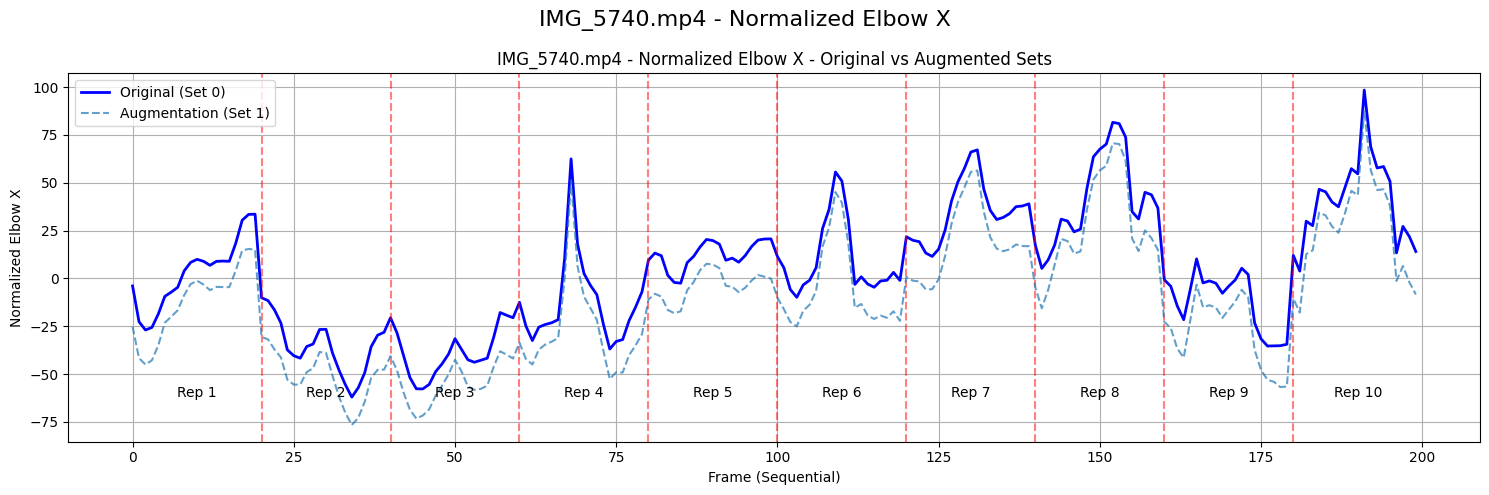

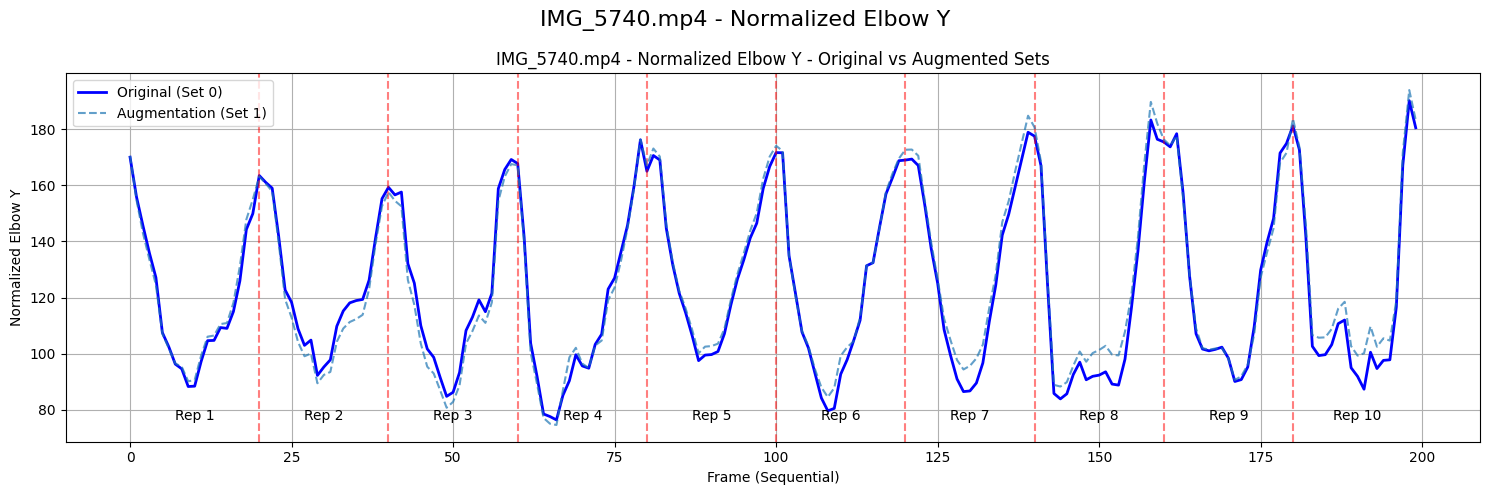

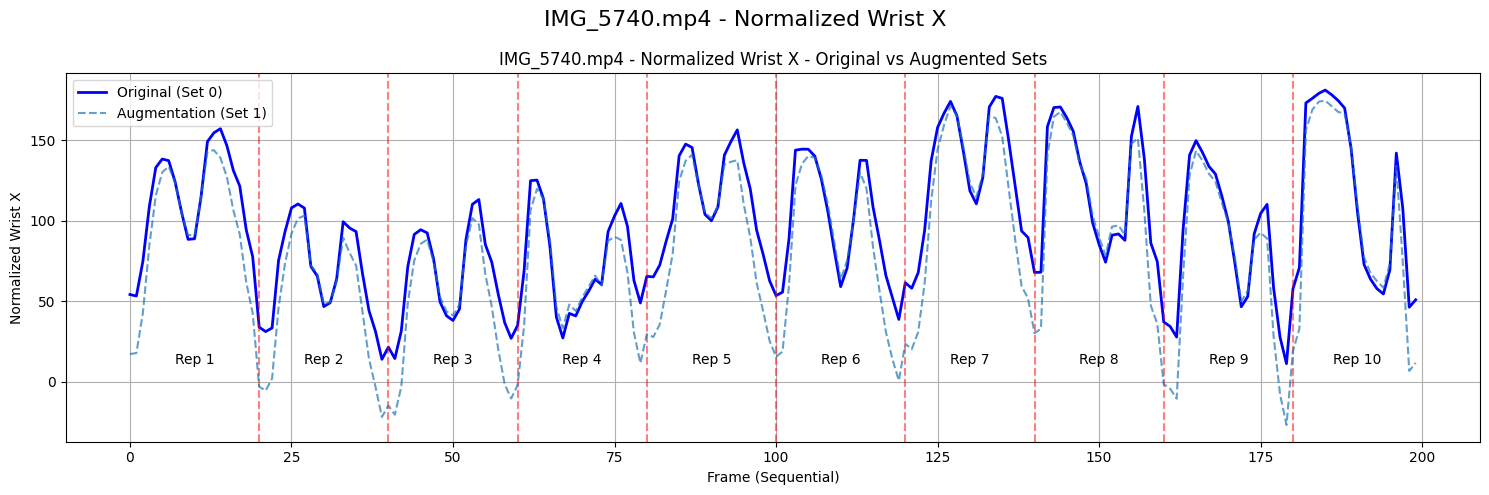

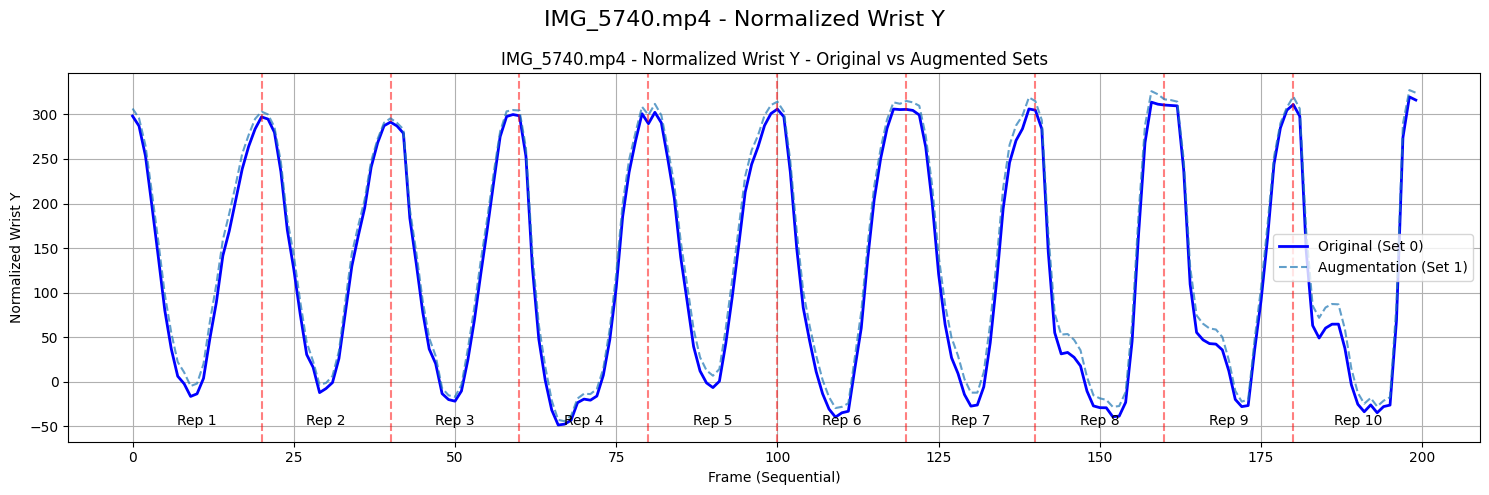

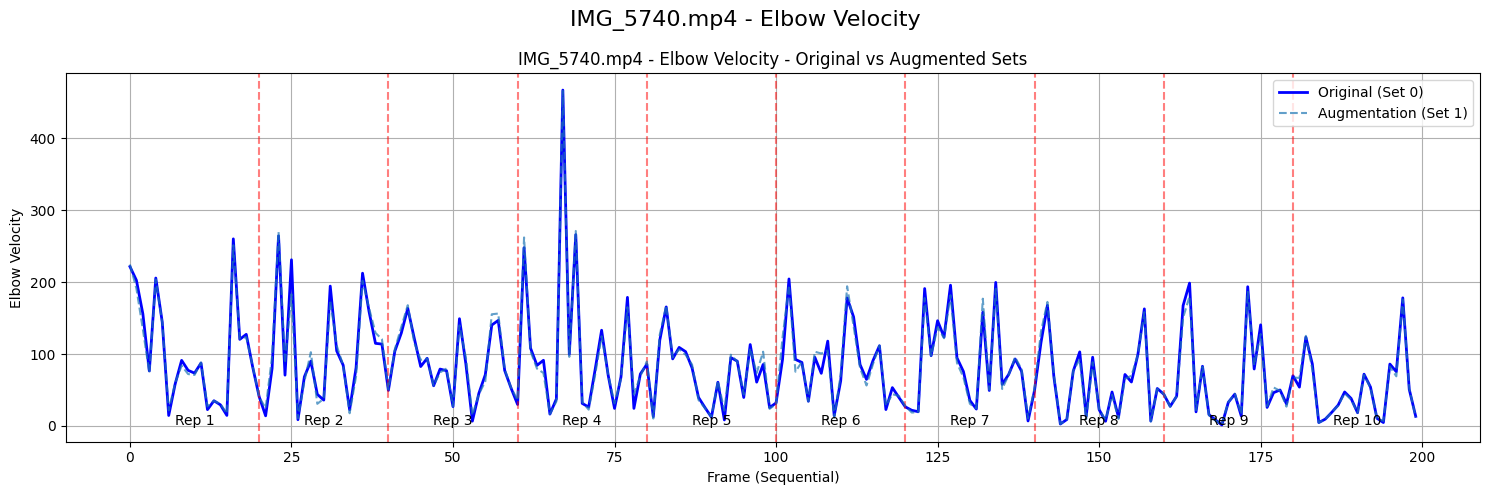

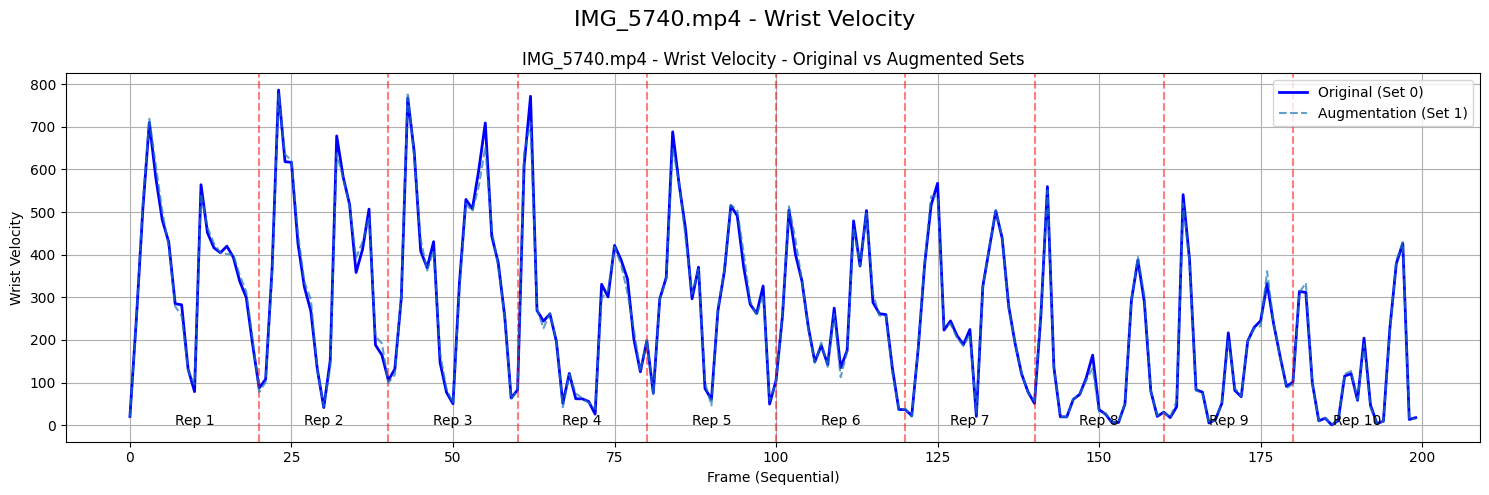

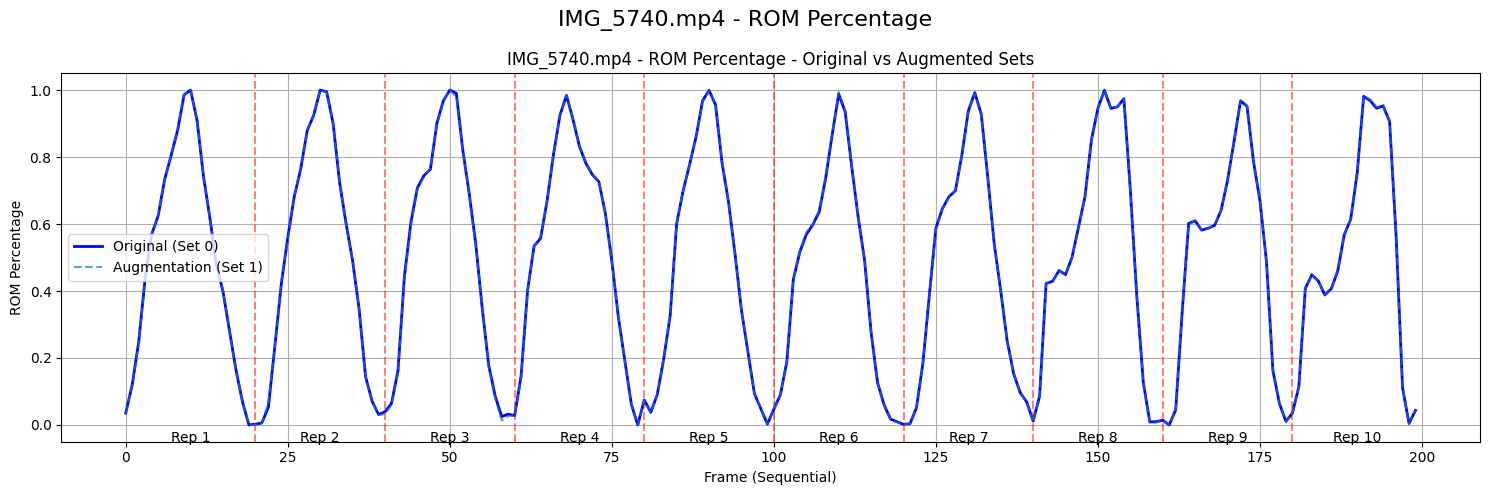

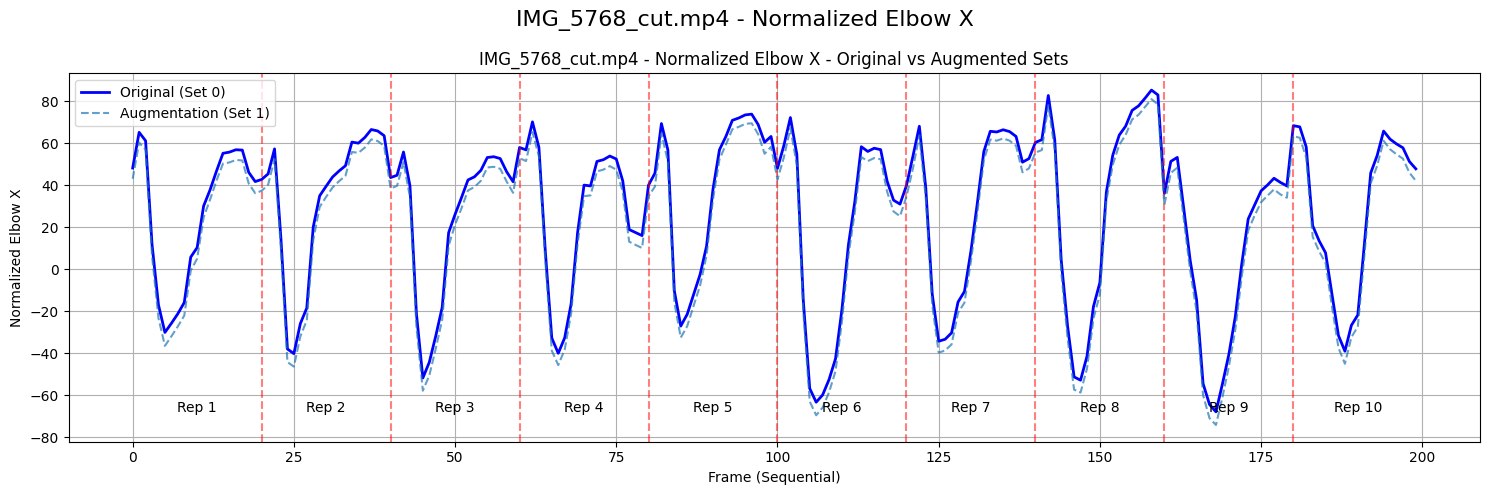

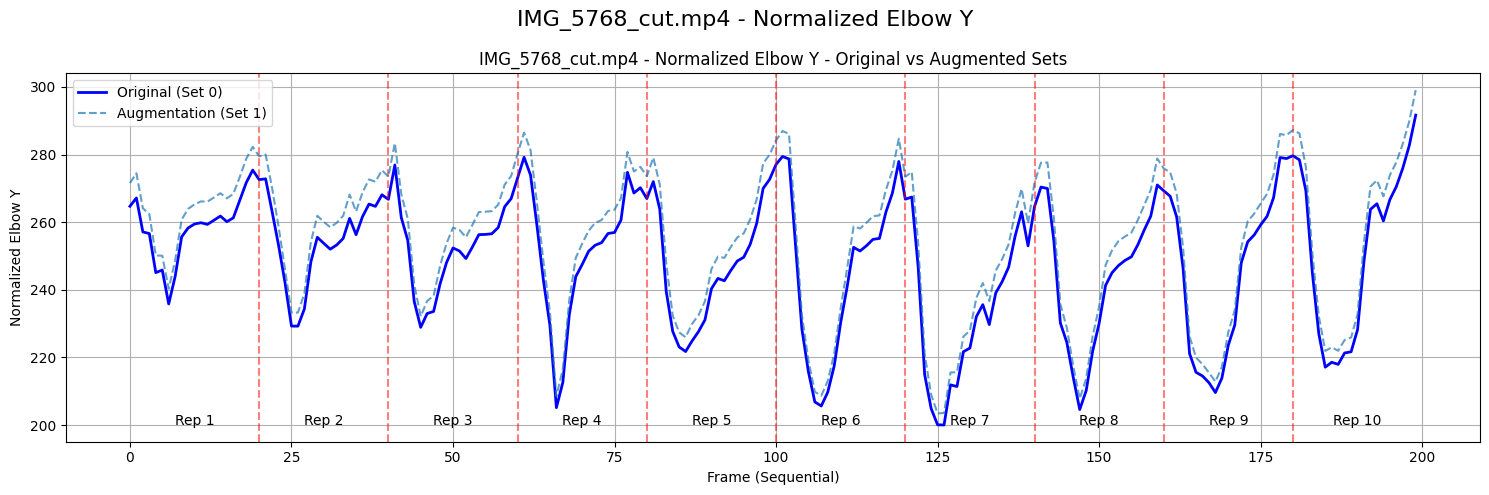

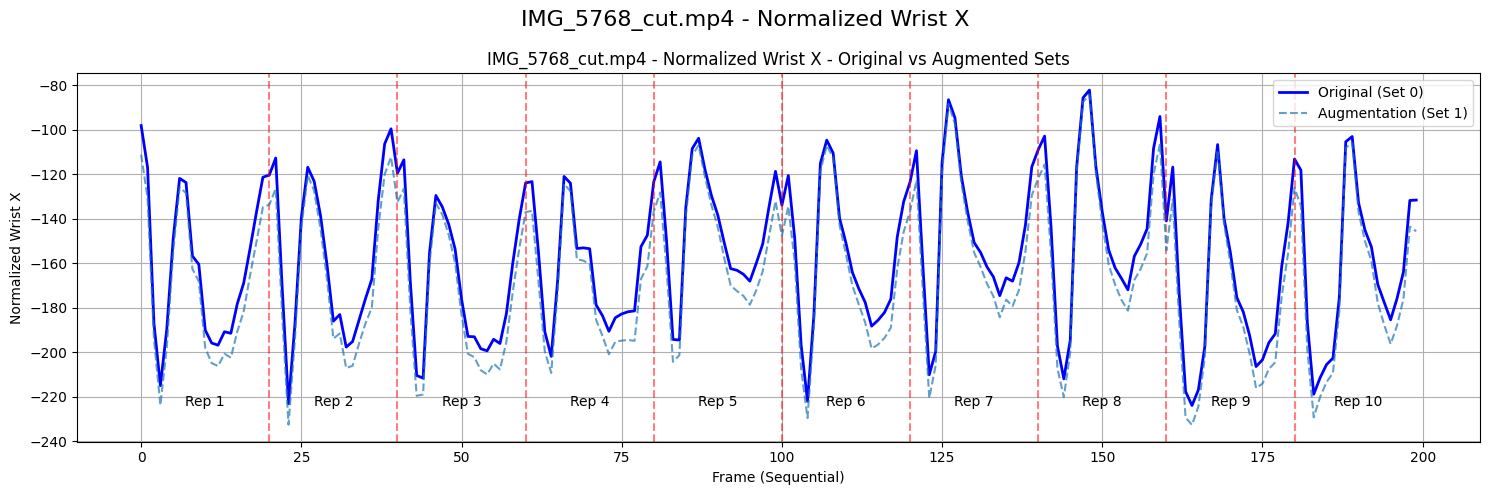

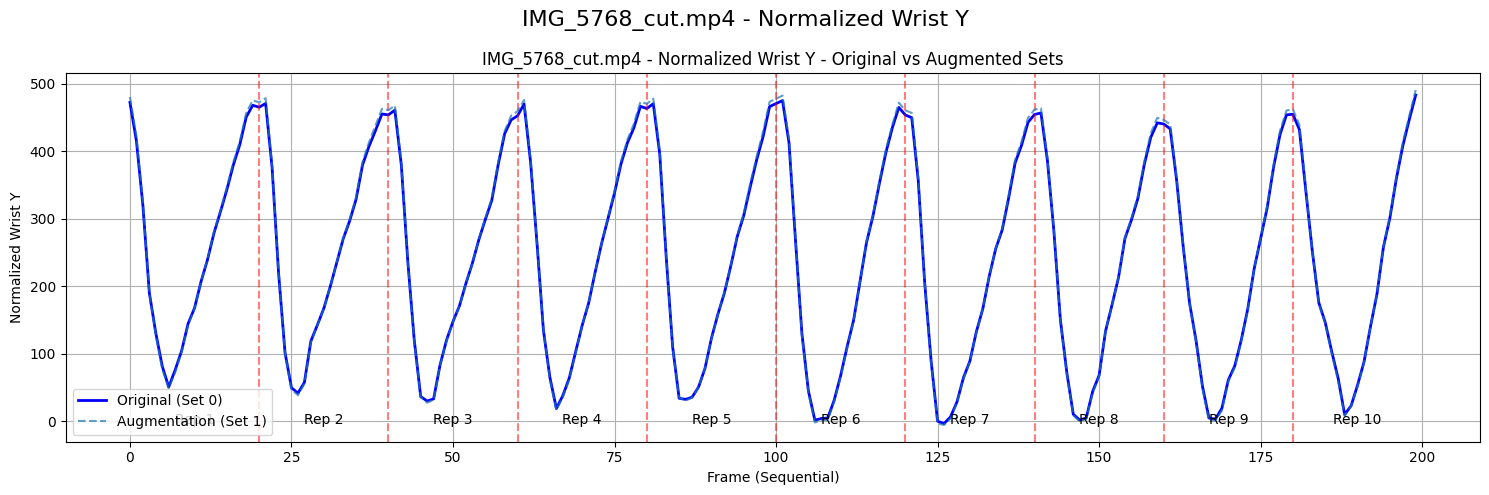

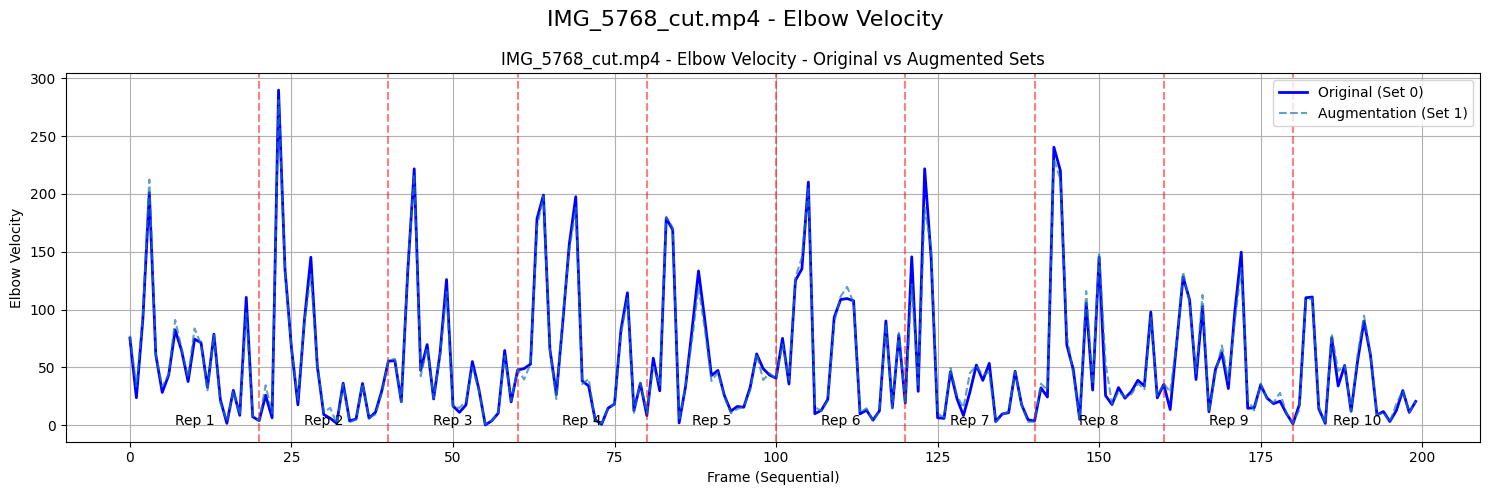

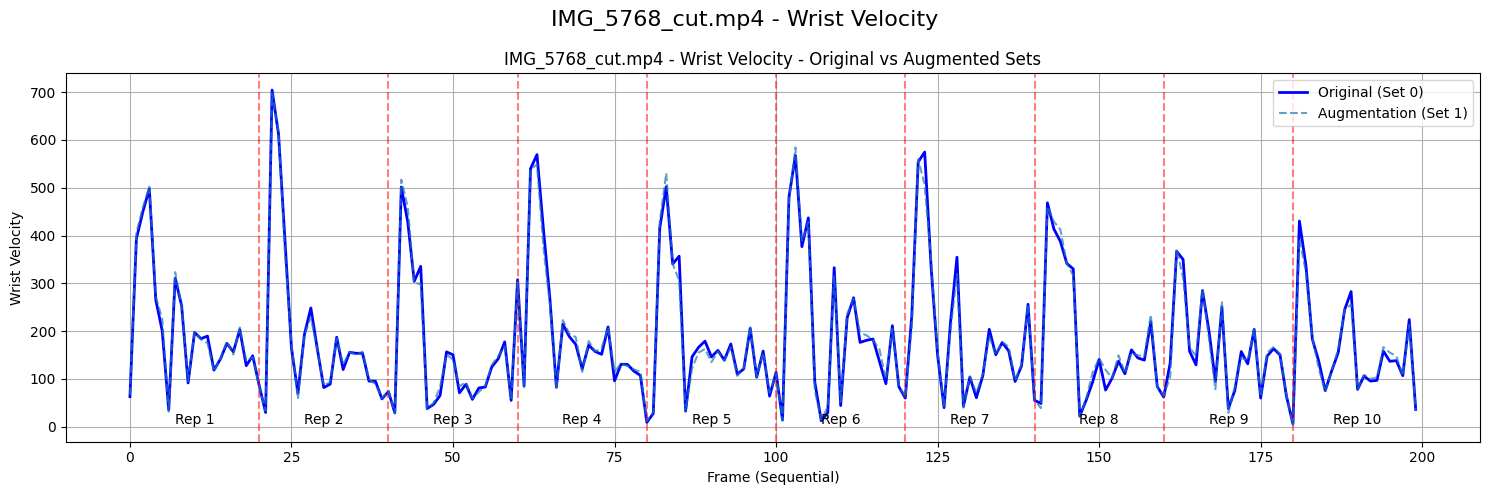

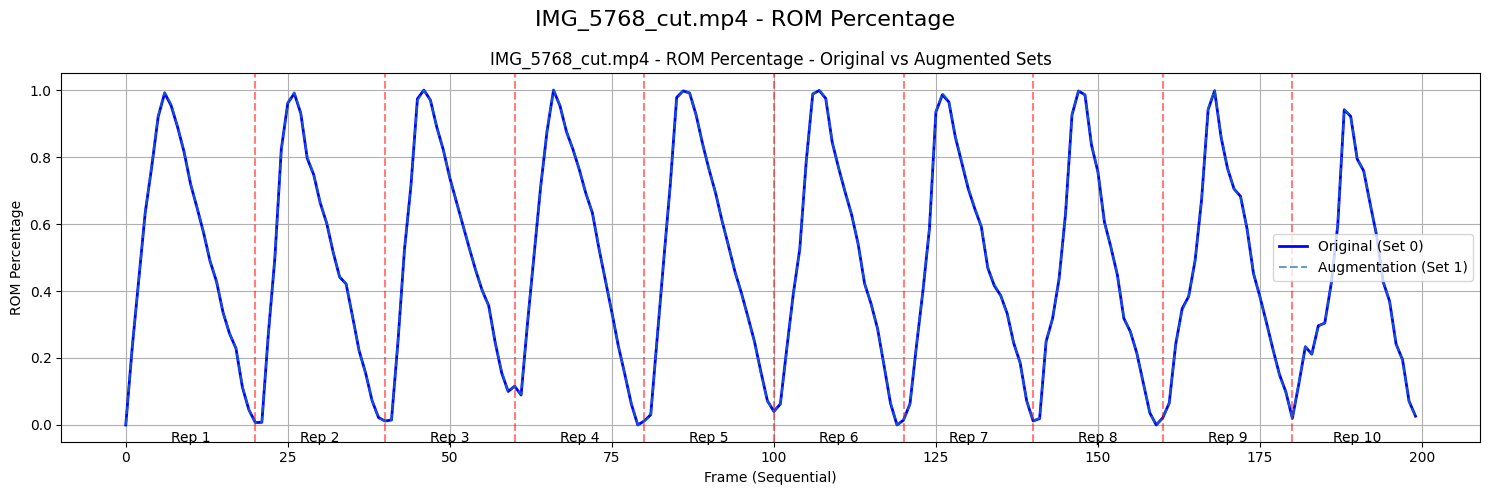

KeyboardInterrupt: 

In [ ]:
print(processed_all_sets_data.keys())

# Group sets by video name
video_groups = {}
for video_key in processed_all_sets_data.keys():
    video_name = video_key.split('_set_')[0]
    if video_name not in video_groups:
        video_groups[video_name] = []
    video_groups[video_name].append(video_key)

# Get the number of features in the data
sample_rep = processed_all_sets_data[list(processed_all_sets_data.keys())[0]][0]
num_features = sample_rep.shape[1]

# Define feature names
feature_names = [
    "Normalized Elbow X",
    "Normalized Elbow Y",
    "Normalized Wrist X",
    "Normalized Wrist Y",
    "Elbow Velocity",
    "Wrist Velocity",
    "ROM Percentage"
]

# Create a figure with subplots for each feature
plt.figure(figsize=(15, 10))

for video_name, video_keys in video_groups.items():
    # Sort keys to ensure set_0 (original) is processed first
    video_keys.sort(key=lambda x: int(x.split('_set_')[1]))

    # For each feature, create a subplot
    for feature_idx in range(num_features):
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'{video_name} - {feature_names[feature_idx]}', fontsize=16)

        # Process each set for this video
        for video_key in video_keys:
            set_num = video_key.split('_set_')[1]

            # Plot all reps sequentially on the same timeline
            all_feature_data = []
            rep_boundaries = [0]  # Track where each rep starts

            # First collect all rep data sequentially
            for rep_idx, rep_data in enumerate(processed_all_sets_data[video_key]):
                # Extract the current feature
                feature_values = rep_data[:, feature_idx]

                # Add to our sequential data
                all_feature_data.extend(feature_values)
                rep_boundaries.append(rep_boundaries[-1] + len(feature_values))

            # Plot the sequential data with different styles based on set number
            if set_num == '0':
                plt.plot(range(len(all_feature_data)), all_feature_data, 'b-',
                         linewidth=2, label=f'Original (Set {set_num})')

                # Add vertical lines to mark rep boundaries for original set only
                for boundary in rep_boundaries[1:-1]:  # Skip first and last
                    plt.axvline(x=boundary, color='r', linestyle='--', alpha=0.5)

                # Add rep number annotations for original set only
                for i in range(len(rep_boundaries)-1):
                    mid_point = (rep_boundaries[i] + rep_boundaries[i+1]) // 2
                    plt.text(mid_point, min(all_feature_data) - 0.05, f'Rep {i+1}',
                             horizontalalignment='center')
            else:
                plt.plot(range(len(all_feature_data)), all_feature_data,
                         linestyle='--', alpha=0.7, label=f'Augmentation (Set {set_num})')

        plt.title(f'{video_name} - {feature_names[feature_idx]} - Original vs Augmented Sets')
        plt.xlabel('Frame (Sequential)')
        plt.ylabel(f'{feature_names[feature_idx]}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
import pandas as pd


processed_set = [prepare_rep_for_lstm_quantiles(rep, fps=30, num_quantiles=45) for rep in all_sets_list[20]]

# Create a pandas DataFrame
rep_data = processed_set[8]  # Data for the first repetition
feature_names = [
    "Normalized Elbow X",
    "Normalized Elbow Y",
    "Normalized Wrist X",
    "Normalized Wrist Y",
    "Elbow Velocity",
    "Wrist Velocity",
    "ROM Percentage"
]
df = pd.DataFrame(rep_data, columns=feature_names)

# Display the DataFrame as a table
display(df)

,Normalized Elbow X,Normalized Elbow Y,Normalized Wrist X,Normalized Wrist Y,Elbow Velocity,Wrist Velocity,ROM Percentage
0,-3.1969,242.6083,-74.4769,479.8223,11.3811,77.2894,0.0205
1,-4.0832,242.7788,-71.5756,485.9412,16.9723,124.1637,0.0106
2,-4.3262,244.3196,-67.4644,489.3087,21.7954,47.9725,0.0048
3,-3.7849,245.7428,-63.1826,488.1847,39.5132,48.3818,0.0000
4,6.0751,247.2741,-64.4716,480.3947,368.4492,166.5203,0.0463
5,36.8523,247.0902,-65.0326,461.0375,371.6695,439.9593,0.1638
6,57.5556,244.0913,-64.8415,434.6895,414.9124,310.8736,0.2186
7,84.0228,236.7818,-69.8943,409.1213,310.1820,629.5686,0.3119
8,101.2984,232.1990,-99.7045,368.3807,150.9831,721.6491,0.4019
9,107.1333,227.7518,-114.4825,302.1799,33.1178,602.1329,0.4742


In [ ]:
import random
import numpy as np

def random_rotation(data, max_angle=10):
    """Applies a random rotation to the joint coordinates."""
    angle = random.uniform(-max_angle, max_angle)
    angle_rad = np.deg2rad(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    rotated_data = data.copy()
    for i in range(data.shape[0]):
        # Rotate shoulder, elbow, and wrist coordinates
        shoulder_coords = data[i, :2]
        elbow_coords = data[i, 2:4]
        wrist_coords = data[i, 4:6]

        rotated_shoulder = rotation_matrix @ shoulder_coords
        rotated_elbow = rotation_matrix @ elbow_coords
        rotated_wrist = rotation_matrix @ wrist_coords

        rotated_data[i, :2] = rotated_shoulder  # Update shoulder coordinates
        rotated_data[i, 2:4] = rotated_elbow     # Update elbow coordinates
        rotated_data[i, 4:6] = rotated_wrist     # Update wrist coordinates

    return rotated_data

In [ ]:

import pandas as pd
def process_all_sets(all_sets, fps=30, num_quantiles=20, augment=True, num_augmentations=3):
    processed_data = {}

    for video_name, reps_list in all_sets.items():
        # Original set key
        processed_data[f"{video_name}_set_0"] = [
            prepare_rep_for_lstm_quantiles(rep, fps, num_quantiles) for rep in reps_list
        ]

        # Generate and store augmented sets
        if augment:
            for aug_idx in range(1, num_augmentations + 1):
                new_set = []
                for rep in reps_list:
                    # Apply augmentations
                    aug_rep = augment_time_series(rep, speed_range=(0.95, 1.05), noise_std=0.02)
                    aug_rep = random_rotation(aug_rep, max_angle=5)
                    aug_rep = random_scaling(aug_rep, scale_range=(0.95, 1.05))

                    # Process augmented rep with quantiles
                    processed_rep = prepare_rep_for_lstm_quantiles(aug_rep, fps, num_quantiles)
                    new_set.append(processed_rep)

                # Save this set under a unique key
                processed_data[f"{video_name}_set_{aug_idx}"] = new_set

    return processed_data



# Assuming 'all_sets' is loaded as in your code
processed_all_sets_data = process_all_sets(all_sets, augment=True)
print(len(processed_all_sets_data))




1008


In [ ]:
print(processed_all_sets_data.keys())

dict_keys(['IMG_5740.mp4_set_0', 'IMG_5740.mp4_set_1', 'IMG_5768_cut.mp4_set_0', 'IMG_5768_cut.mp4_set_1', 'IMG_5805_cut.mp4_set_0', 'IMG_5805_cut.mp4_set_1', 'IMG_5772a_cut.mp4_set_0', 'IMG_5772a_cut.mp4_set_1', 'IMG_9031.mp4_set_0', 'IMG_9031.mp4_set_1', 'IMG_9027.mp4_set_0', 'IMG_9027.mp4_set_1', 'IMG_7768.mp4_set_0', 'IMG_7768.mp4_set_1', 'IMG_6049.mp4_set_0', 'IMG_6049.mp4_set_1', '11r (1).mp4_set_0', '11r (1).mp4_set_1', 'IMG_9023.mp4_set_0', 'IMG_9023.mp4_set_1', 'IMG_5778_cut.mp4_set_0', 'IMG_5778_cut.mp4_set_1', 'IMG_9021.mp4_set_0', 'IMG_9021.mp4_set_1', 'IMG_9024.mp4_set_0', 'IMG_9024.mp4_set_1', 'IMG_9037.mp4_set_0', 'IMG_9037.mp4_set_1', 'IMG_9030.mp4_set_0', 'IMG_9030.mp4_set_1', 'IMG_5757_cut.mp4_set_0', 'IMG_5757_cut.mp4_set_1', 'IMG_9025.mp4_set_0', 'IMG_9025.mp4_set_1', '10r (1).mp4_set_0', '10r (1).mp4_set_1', 't4.mp4_set_0', 't4.mp4_set_1', 'IMG_9033.mp4_set_0', 'IMG_9033.mp4_set_1', 'IMG_6048.mp4_set_0', 'IMG_6048.mp4_set_1', 'IMG_5976.mp4_set_0', 'IMG_5976.mp4_set

In [ ]:
# Example usage to display the processed data for the first video and first rep:

first_video_name = list(processed_all_sets_data.keys())[7]
first_rep_data = processed_all_sets_data[first_video_name][0]
print(len(processed_all_sets_data[first_video_name]))
print(first_video_name)
feature_names = [
    "Normalized Elbow X",
    "Normalized Elbow Y",
    "Normalized Wrist X",
    "Normalized Wrist Y",
    "Elbow Velocity",
    "Wrist Velocity",
    "ROM Percentage"
]

df = pd.DataFrame(first_rep_data, columns=feature_names)
display(df)

18
IMG_5772a_cut.mp4_set_1


,Normalized Elbow X,Normalized Elbow Y,Normalized Wrist X,Normalized Wrist Y,Elbow Velocity,Wrist Velocity,ROM Percentage
0,-3.140518,266.957834,-40.536162,503.514463,54.209473,124.055787,0.000000
1,28.842760,258.154510,-41.636732,480.929755,398.092648,375.908457,0.112366
2,75.080163,235.536016,-47.761172,433.744317,242.849225,346.204547,0.286225
3,97.085807,228.778385,-90.312566,369.932777,47.840055,555.125765,0.473220
4,92.971226,225.210839,-135.201721,286.367733,88.340858,578.945733,0.631152
5,77.908185,218.527925,-160.913510,214.095958,152.095677,537.577537,0.739505
6,39.534649,211.592900,-173.370930,136.803551,224.740387,324.097908,0.815835
7,6.615911,207.010334,-167.495227,82.375717,216.915911,380.239306,0.889463
8,-12.422107,203.079891,-147.105770,31.286112,90.929774,254.049124,0.992772
9,-7.942321,202.564147,-140.671064,36.173393,17.595808,10.040849,0.989550


In [ ]:
# Assuming 'all_sets' is loaded and contains data for multiple videos
first_video_name = list(all_sets.keys())[2]  # Get the name of the first video
first_video_reps = all_sets[first_video_name] # Get all reps for the first video
first_rep = first_video_reps[0]  # Get the first rep of the first video

print(f"Shape of the first rep in {first_video_name}: {first_rep.shape}")
print(f"Data type of the first rep: {first_rep.dtype}")
print(f"First few rows of the first rep:\n{first_rep[:5]}")  # Print first 5 rows

Shape of the first rep in IMG_5776_cut.mp4: (50, 6)
Data type of the first rep: float64
First few rows of the first rep:
[[325.70345163 441.40899658 300.10629416 670.46157837 336.3428092
  872.60971069]
 [325.71151972 435.31639099 298.83801699 665.26512146 335.2302289
  868.77059937]
 [326.05628014 433.70441437 295.56439161 663.26217651 336.64051294
  869.17831421]
 [324.49828148 434.82414246 285.91476917 667.7973175  338.52483988
  869.51545715]
 [324.63870049 439.53140259 278.84671926 674.85237122 342.06209421
  871.39053345]]


In [ ]:
# import torch.nn.functional as F

# def hinge_bce_loss(predictions, targets, margin=0.5, last_rep_weight=0.5):
#     targets = targets.float()
#     last_rep_idx = targets.shape[1] - 1  # Get last rep index

#     probs = torch.sigmoid(predictions)  # Convert logits to probabilities

#     # Hinge loss for early reps (should be below margin)
#     early_reps_loss = torch.clamp(probs[:, :-1] - margin, min=0).mean()

#     # BCE loss for the last rep (to encourage it to be higher but not crazy high)
#     last_rep_loss = F.binary_cross_entropy(probs[:, last_rep_idx], targets[:, last_rep_idx])

#     # Reduce the emphasis on last rep loss (smooth transition)
#     total_loss = early_reps_loss + last_rep_weight * last_rep_loss
#     return total_loss



In [ ]:
# class DistanceWeightedBCELoss(nn.Module):
#     def __init__(self, margin=0.5, weight=0.1, false_pos_penalty=2.0, miss_penalty=5.0):
#         """
#         Distance-weighted loss that penalizes incorrect failure predictions
#         based on their distance from the actual failure rep.

#         Args:
#         - margin: threshold for considering a prediction as failure.
#         - weight: weight for distance penalty.
#         - false_pos_penalty: penalty for predicting failure too early.
#         - miss_penalty: penalty for missing the failure rep.
#         """
#         super(DistanceWeightedBCELoss, self).__init__()
#         self.margin = margin
#         self.weight = weight
#         self.false_pos_penalty = false_pos_penalty
#         self.miss_penalty = miss_penalty
#         self.bce = nn.BCEWithLogitsLoss()

#     def forward(self, logits, labels):
#         probs = torch.sigmoid(logits)  # Convert logits to probabilities
#         batch_size, seq_len = labels.shape

#         # 🔹 Find actual failure rep (last "1" in labels)
#         failure_indices = (labels == 1).nonzero(as_tuple=True)
#         actual_fail_idx = failure_indices[1] if failure_indices[0].numel() > 0 else None

#         # 🔹 Find first predicted failure rep (first rep > 0.5)
#         predicted_fail_mask = (probs > self.margin).float()
#         predicted_fail_indices = (predicted_fail_mask.cumsum(dim=1) == 1).float().argmax(dim=1)

#         # 🔹 Compute distance penalty (only if failure exists)
#         if actual_fail_idx is not None:
#             distance = (predicted_fail_indices - actual_fail_idx).float().abs()
#             penalty = (distance / seq_len).mean() * self.weight  # Normalize penalty
#         else:
#             penalty = torch.zeros(batch_size, device=logits.device)

#         # 🔹 False positive penalty (if model predicts failure too early)
#         false_positive_penalty = (predicted_fail_indices < actual_fail_idx).float().mean() * self.false_pos_penalty

#         # 🔹 Miss penalty (if no failure is predicted at all)
#         miss_penalty = (predicted_fail_mask.sum(dim=1) == 0).float().mean() * self.miss_penalty

#         # 🔹 Compute BCE loss
#         bce_loss = self.bce(logits, labels)

#         # 🔹 Total loss (balanced penalties)
#         total_loss = bce_loss + penalty + false_positive_penalty + miss_penalty

#         return total_loss

In [ ]:
# class FirstFailDistanceLoss(nn.Module):
#     def __init__(self, distance_weight=0.001, miss_penalty=0.9):
#         """
#         distance_weight: How much we penalize failure predictions that are too early/late.
#         miss_penalty: Extra penalty when the model completely fails to predict failure.
#         """
#         super(FirstFailDistanceLoss, self).__init__()
#         self.bce = nn.BCEWithLogitsLoss()
#         self.distance_weight = distance_weight
#         self.miss_penalty = miss_penalty  # Force model to always predict failure

#     def forward(self, logits, labels):
#         probs = torch.sigmoid(logits)
#         batch_size, seq_len = labels.shape

#         # Find actual failure rep (should be the last "1" in each sequence)
#         failure_indices = (labels == 1).nonzero(as_tuple=True)
#         actual_fail_idx = failure_indices[1] if failure_indices[0].numel() > 0 else None

#         # Find first predicted failure rep
#         predicted_fail_mask = (probs > 0.5).float()
#         predicted_fail_indices = (predicted_fail_mask.cumsum(dim=1) == 1).float().argmax(dim=1)

#         # Compute distance penalty
#         if actual_fail_idx is not None:
#             distance = (predicted_fail_indices - actual_fail_idx).float().abs()
#             penalty = (distance / seq_len).mean()  # Linear penalty

#             # **Force failure prediction:**
#             miss_penalty = (predicted_fail_mask.sum(dim=1) == 0).float().mean() * self.miss_penalty  # If no failure is predicted, add penalty
#         else:
#             penalty = torch.zeros(batch_size, device=logits.device)
#             miss_penalty = torch.zeros(batch_size, device=logits.device)  # No extra penalty if there's no actual failure (shouldn't happen)

#         # BCE loss
#         bce_loss = self.bce(logits, labels)

#         # Push loss to encourage non-zero predictions
#         push_loss = -0.005 * logits.mean()  # Small encouragement to push values up

#         # Total loss
#         total_loss = bce_loss + self.distance_weight * penalty + miss_penalty + push_loss
#         return total_loss


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import numpy as np

# # ---------------------------
# # 1. Custom Dataset
# # ---------------------------
# class RepDataset(Dataset):
#     """
#     Custom Dataset for handling reps stored in a dictionary.
#     Each key corresponds to one set (e.g., one video), and the value is a list of 5x7 NumPy arrays.
#     Each rep is flattened to a 70-dim vector.
#     The labels are 0 for all reps except the last rep, which is labeled 1.
#     """
#     def __init__(self, data_dict):
#         self.data = []  # list of (sequence, labels)
#         for key, reps in data_dict.items():
#             # Flatten each 5x7 rep into a 70-dim vector.
#             reps_flat = [rep.flatten() for rep in reps]
#             # Create label: 0 for all except the last rep is 1.
#             labels = [0] * (len(reps_flat) - 1) + [1]
#             # Stack into an array with shape (seq_len, 35) and (seq_len,) for labels.
#             sequence = np.stack(reps_flat)  # shape: (seq_len, 35)
#             labels = np.array(labels)         # shape: (seq_len,)
#             self.data.append((sequence, labels))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sequence, labels = self.data[idx]
#         # Convert to torch tensors.
#         sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
#         labels_tensor = torch.tensor(labels, dtype=torch.float32)
#         return sequence_tensor, labels_tensor

# # Example data dictionary (using your provided example snippet)
# data = processed_all_sets_data


# import random

# # 1. Split the data
# video_names = list(processed_all_sets_data.keys())
# random.shuffle(video_names)  # Shuffle the video names
# split_index = int(0.8 * len(video_names))  # 80% for training
# train_video_names = video_names[:split_index]
# val_video_names = video_names[split_index:]

# # 2. Create training and validation data dictionaries
# train_data = {key: processed_all_sets_data[key] for key in train_video_names}
# val_data = {key: processed_all_sets_data[key] for key in val_video_names}

# # 3. Create datasets and data loaders
# train_dataset = RepDataset(train_data)
# val_dataset = RepDataset(val_data)

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # No need to shuffle validation data

# # ---------------------------
# # 2. Model Implementation
# # ---------------------------
# class RepEncoder(nn.Module):
#     """
#     Encodes each rep (5x7 matrix flattened to a 35-dim vector) into a feature vector.
#     """
#     def __init__(self, input_dim=70, embed_dim=64):
#         super(RepEncoder, self).__init__()
#         self.fc = nn.Linear(input_dim, embed_dim)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # x shape: (batch_size, seq_len, 35)
#         out = self.fc(x)  # shape: (batch_size, seq_len, embed_dim)
#         out = self.relu(out)
#         return out

# class LSTMClassifier(nn.Module):
#     """
#     Overall model:
#       1. Each rep is optionally encoded via RepEncoder.
#       2. An LSTM processes the sequence.
#       3. At each timestep, the LSTM hidden state is passed to a classifier.
#     """
#     def __init__(self, input_dim=70, embed_dim=64, lstm_hidden_dim=128, num_layers=1, use_encoder=False):
#         super(LSTMClassifier, self).__init__()
#         self.use_encoder = use_encoder
#         if use_encoder:
#             self.encoder = RepEncoder(input_dim=input_dim, embed_dim=embed_dim)
#             lstm_input_dim = embed_dim
#         else:
#             lstm_input_dim = input_dim

#         self.lstm = nn.LSTM(input_size=lstm_input_dim, hidden_size=lstm_hidden_dim,
#                             num_layers=num_layers, batch_first=True)
#         # Binary classifier: single output (logit) per timestep.
#         self.classifier = nn.Linear(lstm_hidden_dim, 1)

#     def forward(self, x, hidden=None):
#         """
#         x: tensor of shape (batch_size, seq_len, input_dim) (input_dim=35)
#         Returns:
#             logits: tensor of shape (batch_size, seq_len)
#         """
#         if self.use_encoder:
#             x = self.encoder(x)  # shape becomes (batch_size, seq_len, embed_dim)

#         lstm_out, hidden = self.lstm(x, hidden)  # lstm_out: (batch_size, seq_len, lstm_hidden_dim)
#         logits = self.classifier(lstm_out)  # shape: (batch_size, seq_len, 1)
#         return logits.squeeze(-1), hidden  # final shape: (batch_size, seq_len)

# # ---------------------------
# # 3. Training Setup
# # ---------------------------
# # Hyperparameters
# learning_rate = 1e-3
# lstm_hidden_dim = 32
# embed_dim = 16

# model = LSTMClassifier(input_dim=70, embed_dim=embed_dim, lstm_hidden_dim=lstm_hidden_dim, num_layers=1)
# # Use BCEWithLogitsLoss (binary classification) with a positive class weight.
# # Here pos_weight is tuned to give more weight to the failure (rare) class.
# pos_weight = torch.tensor([10.0])

# # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# # criterion = hinge_bce_loss
# criterion = DistanceWeightedBCELoss()  # Adjust lambda as needed
# # criterion = FirstFailDistanceLoss()


# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


# # ---------------------------
# # 4. Training Loop (Example)
# # ---------------------------
# model.train()
# for epoch in range(50):
#     epoch_loss = 0.0
#     for sequences, labels in train_dataloader:
#         # sequences shape: (batch_size, seq_len, 35)
#         # labels shape: (batch_size, seq_len)
#         optimizer.zero_grad()
#         logits, _ = model(sequences)  # logits shape: (batch_size, seq_len)
#         loss = criterion(logits, labels)
#         epoch_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         # print(f"Epoch {epoch+1} - Loss: {loss.item()}")
#     epoch_loss /= len(train_dataloader)
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation during validation
#         for sequences, labels in val_dataloader:
#             logits, _ = model(sequences)
#             loss = criterion(logits, labels)
#             val_loss += loss.item()
#     val_loss /= len(val_dataloader)
#     print(f"Epoch {epoch+1} - Average Training Loss: {epoch_loss}, Validation Loss: {val_loss}")

# # ---------------------------
# # 5. Evaluation Example
# # ---------------------------
# # model.eval()
# # with torch.no_grad():
# #     for sequences, labels in val_dataloader:
# #         logits, _ = model(sequences)
# #         # Convert logits to probabilities
# #         probabilities = torch.sigmoid(logits)
# #         print("Predicted probabilities per rep:")
# #         print(probabilities)
# #         print("Ground truth labels:")
# #         print(labels)


In [ ]:
# # ---------------------------
# # 5. Evaluation Example
# # ---------------------------
# model.eval()
# with torch.no_grad():
#     for sequences, labels in val_dataloader:
#         logits, _ = model(sequences)
#         # Convert logits to probabilities
#         probabilities = torch.sigmoid(logits)
#         print("Predicted probabilities per rep:")
#         print(probabilities)
#         print("Ground truth labels:")
#         print(labels)

In [ ]:
import random
from collections import defaultdict

# Suppose "processed_all_sets_data" has keys like:
# t1.mp4_set_1, t1.mp4_set_2, t2.mp4_set_1, t2.mp4_set_2, etc.

# 1) Group by the original video "base name"
group_to_keys = defaultdict(list)

for key in processed_all_sets_data.keys():
    # Extract the base name before "_set_"
    base_name = key.split("_set_")[0]  # "t1.mp4"

    # Group them
    group_to_keys[base_name].append(key)

# 2) Create a list of the groups (i.e. the base videos)
groups = list(group_to_keys.keys())
random.shuffle(groups)

# 3) Split on a group level (70% train, 15% val, 15% test)
num_train = int(0.6 * len(groups))
num_val   = int(0.2 * len(groups))
num_test  = len(groups) - num_train - num_val  # Ensure all groups are allocated

train_groups = groups[:num_train]
val_groups   = groups[num_train:num_train + num_val]
test_groups  = groups[num_train + num_val:]

# 4) Distribute the data
train_data = {}
val_data   = {}
test_data  = {}

for g in train_groups:
    for key in group_to_keys[g]:
        train_data[key] = processed_all_sets_data[key]

for g in val_groups:
    # Only include the original set (set_0) for validation
    key = f"{g}_set_0"
    val_data[key] = processed_all_sets_data.get(key, [])

for g in test_groups:
    # Only include the original set (set_0) for testing
    key = f"{g}_set_0"
    test_data[key] = processed_all_sets_data.get(key, [])

print(len(train_data))
print(len(val_data))
print(len(test_data))

302
50
51


In [ ]:
# save / load split if needed

import json
import random
from collections import defaultdict

def save_split_to_json(train_data, val_data, test_data, filename="data_split.json"):
    """Saves the data split to a JSON file."""
    split_dict = {
        "train": list(train_data.keys()),  # Store only keys for train
        "val": list(val_data.keys()),      # Store only keys for val
        "test": list(test_data.keys())     # Store only keys for test
    }
    with open(filename, "w") as f:
        json.dump(split_dict, f, indent=4)

def load_split_from_json(processed_all_sets_data, filename="data_split.json"):
    """Loads the data split from a JSON file and applies it to the data."""
    with open(filename, "r") as f:
        split_dict = json.load(f)

    train_data = {key: processed_all_sets_data[key] for key in split_dict["train"]}
    val_data = {key: processed_all_sets_data[key] for key in split_dict["val"]}
    test_data = {key: processed_all_sets_data[key] for key in split_dict["test"]}

    return train_data, val_data, test_data



# Save the split
save_split_to_json(train_data, val_data, test_data)


# Load the split
# train_data, val_data, test_data = load_split_from_json(processed_all_sets_data)

print(len(train_data))
print(len(val_data))
print(len(test_data))

302
50
51


In [ ]:
import copy
import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F

def distance_weighted_bce_loss(logits, labels, dist_from_fail, distance_weight=0.7):
    """
    Calculates a distance-weighted BCE loss.

    Args:
        logits: Model predictions (before sigmoid).
        labels: True labels (0 or 1).
        dist_from_fail: Distance of the window from the failure point.

    Returns:
        The distance-weighted loss.
    """
    bce_loss = F.binary_cross_entropy_with_logits(logits, labels)

    # Calculate distance penalty (only for incorrect predictions)
    probs = torch.sigmoid(logits)
    incorrect_predictions = (probs > 0.5) != labels.bool()

    # Scale dist_from_fail to be in [0, 1]
    max_distance = torch.max(dist_from_fail)  # Get the maximum distance in the batch
    scaled_distances = dist_from_fail / max_distance if max_distance > 0 else torch.zeros_like(dist_from_fail)

    # Apply distance weight to incorrect predictions (failure predictions only)
    failure_predictions = probs > 0.5  # Get predictions where model predicted failure
    weighted_distances = scaled_distances * failure_predictions.float()  # Multiply by 0 if not failure prediction

    distance_penalty = torch.mean(weighted_distances[incorrect_predictions])  # Only use incorrect predictions

    # Combine BCE loss and distance penalty
    total_loss = bce_loss + distance_weight * distance_penalty

    return total_loss


class SlidingWindowRepDataset(Dataset):
    """
    Custom Dataset for handling reps stored in a dictionary.
    Each key corresponds to one set (e.g., one video), and the value is a list of 5x9 NumPy arrays.
    """
    def __init__(self, data_dict, balance_ratio=0.5, window_size=3, seed=123, near_failure_ratio=0.5):
        self.samples = []
        fail_samples = []
        non_fail_samples = []
        self.window_size = window_size
        self.seed = seed
        self.near_failure_ratio = near_failure_ratio

        random.seed(self.seed)

        for key, list_of_reps in data_dict.items():
            if not list_of_reps:  # If empty, skip this video
                continue
            reps = np.stack(list_of_reps, axis=0)  # (R, 10, frame_dim)
            R = reps.shape[0]

            if R < window_size:
                continue  # Skip very short sequences

            for i in range(R - (window_size - 1)):
                window = reps[i : i + window_size]
                fail = 1 if (i + window_size == R) else 0
                rul = R - (i + window_size)  # number of reps remaining until failure

                dist_from_fail = R - (i + window_size) # get distance of last rep in window from fail

                if dist_from_fail <= 8:

                  if fail:
                      fail_samples.append((window, rul))
                  else:
                      # Determine if this is a near-failure sample
                      is_near_failure = (i + window_size) >= (R - 2)  # Within 2 reps of failure

                      # Add to non-fail samples based on near_failure_ratio
                      if is_near_failure:
                          non_fail_samples.append((window, rul))
                      elif random.random() < (1 - self.near_failure_ratio):  # Add other non-fail samples
                          non_fail_samples.append((window, rul))

        # Balance 50/50 fail vs. non-fail
        num_fail = len(fail_samples)
        num_non_fail = int(num_fail / balance_ratio * (1 - balance_ratio))
        # non_fail_samples = random.sample(non_fail_samples, min(num_non_fail, len(non_fail_samples)))

        # Use the random seed to shuffle non_fail_samples consistently
        random.shuffle(non_fail_samples)

        non_fail_samples = non_fail_samples[:num_non_fail]


        self.samples = fail_samples + non_fail_samples
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        window, rul = self.samples[idx]
        return torch.tensor(window, dtype=torch.float32), torch.tensor(rul, dtype=torch.float32)

class LSTMFailurePredictor(nn.Module):
    def __init__(self, frame_dim=9, rep_hidden_dim=32, lstm_hidden_dim=64, dropout=0.0, num_lstm_layers=1, window_size=3):
        super().__init__()
        self.window_size = window_size  # Store window size as attribute
        self.lstm = nn.LSTM(
            input_size=frame_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )
        self.dropout_layer = nn.Dropout(p=dropout)
        self.fc = nn.Linear(lstm_hidden_dim, 1)

    def forward(self, reps):
        B, _, T, F = reps.shape
        reps = reps.view(B * self.window_size, T, F)
        lstm_out, _ = self.lstm(reps)
        lstm_out = self.dropout_layer(lstm_out)
        # take the last time step
        lstm_out = lstm_out[:, -1, :]
        lstm_out = lstm_out.view(B, self.window_size, -1)
        final_rep_encoding = lstm_out[:, -1, :]
        final_rep_encoding = self.dropout_layer(final_rep_encoding)
        logits = self.fc(final_rep_encoding).squeeze(-1)
        return logits



def train_and_eval(
    train_dataloader,
    val_dataloader,
    frame_dim,
    rep_hidden_dim,
    lstm_hidden_dim,
    learning_rate,
    batch_size,
    dropout,
    num_lstm_layers,
    window_size,
    num_epochs=40,
    patience=5,
    device='cpu'
):
    model = LSTMFailurePredictor(
        frame_dim=frame_dim,
        rep_hidden_dim=rep_hidden_dim,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=dropout,
        num_lstm_layers=num_lstm_layers,
        window_size=window_size
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)


    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for reps, rul_targets in train_dataloader:
            reps, rul_targets = reps.to(device), rul_targets.to(device)
            optimizer.zero_grad()
            preds = model(reps)
            loss = criterion(preds, rul_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        rmse_total = 0.0
        with torch.no_grad():
            for reps, rul_targets in val_dataloader:
                reps, rul_targets = reps.to(device), rul_targets.to(device)
                preds = model(reps)
                loss = criterion(preds, rul_targets)
                val_loss += loss.item()

                # Calculate RMSE for this batch
                batch_rmse = torch.sqrt(F.mse_loss(preds, rul_targets))
                rmse_total += batch_rmse.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        avg_rmse = rmse_total / len(val_dataloader)
        print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, RMSE = {avg_rmse:.4f}")


        # Early-stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_val_loss, best_model_state, train_losses, val_losses


In [ ]:
import torch
import numpy as np
import io
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def run_experiments_for_config(
    hparams,
    train_data,
    val_data,
    n_runs=3,
    max_gap_threshold=None,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    val_losses_all_runs = []
    train_losses_final_all_runs = []
    gaps_all_runs = []

    best_val_loss_run = float('inf')
    best_run_idx = -1
    best_train_losses = []
    best_val_losses = []
    best_model_state_buffer = None  # << We'll store the best model weights as a buffer

    base_seed = 12345

    for run_idx in range(n_runs):
        seed = base_seed + run_idx
        torch.manual_seed(seed)
        np.random.seed(seed)

        # train_dataset = VariableLengthRepDataset(train_data, balance_ratio=0.5)
        # val_dataset   = VariableLengthRepDataset(val_data,   balance_ratio=0.5)

        train_dataset = SlidingWindowRepDataset(train_data, balance_ratio=hparams['balance_ratio'], near_failure_ratio=hparams['near_failure_ratio'], window_size=hparams["window_size"])
        val_dataset   = SlidingWindowRepDataset(val_data,   balance_ratio=0.4, near_failure_ratio=0.5, window_size=hparams["window_size"])

        train_dataloader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
        val_dataloader   = DataLoader(val_dataset,   batch_size=hparams['batch_size'], shuffle=False)

        val_loss, best_model_state, train_losses, val_losses = train_and_eval(
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            frame_dim=7,
            rep_hidden_dim=hparams['rep_hidden_dim'],
            lstm_hidden_dim=hparams['lstm_hidden_dim'],
            learning_rate=hparams['learning_rate'],
            batch_size=hparams['batch_size'],
            dropout=hparams['dropout'],
            num_lstm_layers=hparams['num_lstm_layers'],
            num_epochs=75,
            patience=15,
            window_size=hparams['window_size'],
            device=device
        )

        if val_loss < best_val_loss_run:
            best_val_loss_run = val_loss
            best_run_idx = run_idx
            best_train_losses = train_losses
            best_val_losses = val_losses

            # Save model state to a buffer (instead of a file)
            buffer = io.BytesIO()
            torch.save(best_model_state, buffer)  # Serialize model state dict
            best_model_state_buffer = buffer.getvalue()  # Store buffer as binary data

        final_train_loss = train_losses[-1]
        gap = val_loss - final_train_loss

        val_losses_all_runs.append(val_loss)
        train_losses_final_all_runs.append(final_train_loss)
        gaps_all_runs.append(gap)

        if max_gap_threshold is not None and gap > max_gap_threshold:
            pass

    avg_val_loss = float(np.mean(val_losses_all_runs))
    std_val_loss = float(np.std(val_losses_all_runs))
    avg_gap      = float(np.mean(gaps_all_runs))
    avg_train_loss = float(np.mean(train_losses_final_all_runs))

    score = avg_val_loss + 0.5 * abs(avg_gap) + 0.1 * std_val_loss

    results = {
        'hparams': hparams,
        'val_losses': val_losses_all_runs,
        'train_losses_final': train_losses_final_all_runs,
        'gaps': gaps_all_runs,
        'avg_val_loss': avg_val_loss,
        'std_val_loss': std_val_loss,
        'avg_gap': avg_gap,
        'avg_train_loss': avg_train_loss,
        'score': score,
        'epoch_achieved': len(train_losses),
        'best_train_losses': best_train_losses,
        'best_val_losses': best_val_losses,
        'best_model_state': best_model_state_buffer  # Store as binary
    }

    return results


In [ ]:
# Example hyperparam_grid
hyperparam_grid = [

    {'balance_ratio':0.3, 'near_failure_ratio':0.3, 'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.3, 'num_lstm_layers': 1, 'window_size': 3},

    {'balance_ratio':0.3, 'near_failure_ratio':0.3, 'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 5e-3, 'batch_size': 64, 'dropout': 0.3, 'num_lstm_layers': 2, 'window_size': 3},
    {'balance_ratio':0.3, 'near_failure_ratio':0.3, 'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 3e-3, 'batch_size': 64, 'dropout': 0.3, 'num_lstm_layers': 2, 'window_size': 3},


    {'balance_ratio':0.3, 'near_failure_ratio':0.3, 'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 5e-3, 'batch_size': 64, 'dropout': 0.3, 'num_lstm_layers': 3, 'window_size': 3},
    {'balance_ratio':0.3, 'near_failure_ratio':0.3, 'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 5e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 3, 'window_size': 3},
    {'balance_ratio':0.3, 'near_failure_ratio':0.3, 'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 5e-3, 'batch_size': 64, 'dropout': 0.5, 'num_lstm_layers': 3, 'window_size': 3},

    {'balance_ratio':0.3, 'near_failure_ratio':0.3, 'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 3e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 3, 'window_size': 3},














]

    # #lower LR
    # # Base settings
    # {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-3, 'batch_size': 64, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},

    # # Small batch size
    # {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 32, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-3, 'batch_size': 32, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},
    # {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-3, 'batch_size': 32, 'dropout': 0.4, 'num_lstm_layers': 1, 'window_size': 3},








all_results = []
for hparams in hyperparam_grid:
    print(f"Running multiple runs for config: {hparams}")
    config_result = run_experiments_for_config(
        hparams,
        train_data,
        val_data,
        n_runs=3,               # Try 3 runs per config
        max_gap_threshold=0.5,  # Optional: skip or penalize if gap>1.0

    )
    all_results.append(config_result)

# Sort by our combined 'score' (lower is better)
all_results = sorted(all_results, key=lambda x: x['score'])

# # SAME BUT WINDOW 5

#     # Base settings
#     {'rep_hidden_dim': 32, 'lstm_hidden_dim': 64, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 32, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Exploring larger hidden dims
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Smaller learning rate (slower but more stable training)
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Increased batch sizes
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 64, 'dropout': 0.0, 'num_lstm_layers': 1, 'window_size': 5},

#     # Trying dropout (helps prevent overfitting)
#     {'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.15, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 128, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.3, 'num_lstm_layers': 1, 'window_size': 5},
#     {'rep_hidden_dim': 128, 'lstm_hidden_dim': 256, 'learning_rate': 1e-4, 'batch_size': 32, 'dropout': 0.5, 'num_lstm_layers': 1, 'window_size': 5},



Running multiple runs for config: {'balance_ratio': 0.3, 'near_failure_ratio': 0.3, 'rep_hidden_dim': 64, 'lstm_hidden_dim': 128, 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.3, 'num_lstm_layers': 1, 'window_size': 3}
Epoch 0: Val Loss = 6.6006, RMSE = 2.5365


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Val Loss = 5.4550, RMSE = 2.3134
Epoch 2: Val Loss = 5.4102, RMSE = 2.3120
Epoch 3: Val Loss = 5.2180, RMSE = 2.2681
Epoch 4: Val Loss = 5.1140, RMSE = 2.2448
Epoch 5: Val Loss = 4.7695, RMSE = 2.1639
Epoch 6: Val Loss = 4.6950, RMSE = 2.1493
Epoch 7: Val Loss = 4.6188, RMSE = 2.1307
Epoch 8: Val Loss = 4.6029, RMSE = 2.1277
Epoch 9: Val Loss = 4.3437, RMSE = 2.0669
Epoch 10: Val Loss = 4.4376, RMSE = 2.0901
Epoch 11: Val Loss = 4.1457, RMSE = 2.0209
Epoch 12: Val Loss = 3.8503, RMSE = 1.9407
Epoch 13: Val Loss = 3.8045, RMSE = 1.9331
Epoch 14: Val Loss = 3.7168, RMSE = 1.9058
Epoch 15: Val Loss = 3.6701, RMSE = 1.9025
Epoch 16: Val Loss = 3.6806, RMSE = 1.8999
Epoch 17: Val Loss = 3.5659, RMSE = 1.8694
Epoch 18: Val Loss = 3.6007, RMSE = 1.8797
Epoch 19: Val Loss = 3.5790, RMSE = 1.8726
Epoch 20: Val Loss = 3.4529, RMSE = 1.8429
Epoch 21: Val Loss = 3.4433, RMSE = 1.8353
Epoch 22: Val Loss = 3.4027, RMSE = 1.8202
Epoch 23: Val Loss = 3.1468, RMSE = 1.7581
Epoch 24: Val Loss =

In [ ]:

df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

# Summarize val_losses (example: taking mean, min, and max)
df["val_loss_mean"] = df["val_losses"].apply(lambda x: sum(x) / len(x))
df["val_loss_min"] = df["val_losses"].apply(min)
df["val_loss_max"] = df["val_losses"].apply(max)

# Drop the full list column to avoid clutter
df = df.drop(columns=["val_losses"])
df = df.drop(columns=["train_losses_final"])
df = df.drop(columns=["gaps"])
df = df.drop(columns=["best_train_losses"])
df = df.drop(columns=["best_val_losses"])
df = df.drop(columns=["best_model_state"])

# Add ranking column
df.insert(0, "Rank", range(1, len(df) + 1))
import pandas as pd

# Ensure Pandas displays all columns properly
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 200)  # Adjust width for better readability
pd.set_option("display.float_format", "{:.4f}".format)  # Limit float decimals

# Display DataFrame (use in Jupyter Notebook)
from IPython.display import display

display(df)  # Use this instead of print(df)


,Rank,avg_val_loss,std_val_loss,avg_gap,avg_train_loss,score,epoch_achieved,balance_ratio,near_failure_ratio,rep_hidden_dim,lstm_hidden_dim,learning_rate,batch_size,dropout,num_lstm_layers,window_size,val_loss_mean,val_loss_min,val_loss_max
0,1,2.4697,0.0483,-0.4160,2.8856,2.6825,25,0.3000,0.3000,128,256,0.0050,64,0.3000,2,3,2.4697,2.4352,2.5379
1,2,2.6204,0.0962,0.2366,2.3838,2.7484,24,0.3000,0.3000,128,256,0.0030,64,0.3000,2,3,2.6204,2.5109,2.7450
2,3,2.6474,0.1074,-0.2796,2.9270,2.7980,22,0.3000,0.3000,128,256,0.0030,64,0.4000,3,3,2.6474,2.4963,2.7366
3,4,2.6518,0.0518,-0.8406,3.4924,3.0773,28,0.3000,0.3000,128,256,0.0050,64,0.3000,3,3,2.6518,2.5871,2.7139
4,5,2.7997,0.0336,-0.6559,3.4556,3.1310,20,0.3000,0.3000,128,256,0.0050,64,0.4000,3,3,2.7997,2.7759,2.8473
5,6,3.0662,0.0293,-0.2609,3.3271,3.1996,47,0.3000,0.3000,64,128,0.0010,64,0.3000,1,3,3.0662,3.0298,3.1015
6,7,2.5881,0.1006,-1.2679,3.8561,3.2322,24,0.3000,0.3000,128,256,0.0050,64,0.5000,3,3,2.5881,2.4536,2.6957


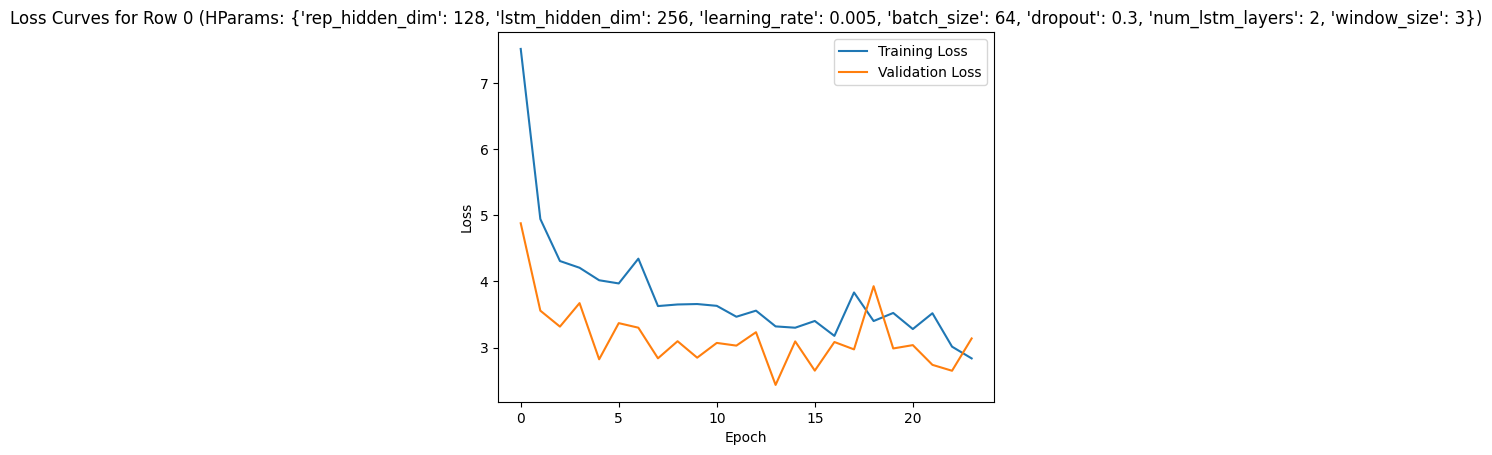

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_loss_curves_for_row(row_index, df):
    """Plots training and validation loss curves for a specific row in the DataFrame."""

    hparams = {  # Reconstruct the hparams dictionary from the row
        'rep_hidden_dim': df.loc[row_index, 'rep_hidden_dim'],
        'lstm_hidden_dim': df.loc[row_index, 'lstm_hidden_dim'],
        'learning_rate': df.loc[row_index, 'learning_rate'],
        'batch_size': df.loc[row_index, 'batch_size'],
        'dropout': df.loc[row_index, 'dropout'],
        'num_lstm_layers': df.loc[row_index, 'num_lstm_layers'],
        'window_size': df.loc[row_index, 'window_size']
    }

    train_losses = df.loc[row_index, 'best_train_losses']  # Assuming you stored them
    val_losses = df.loc[row_index, 'best_val_losses']  # Assuming you stored them

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curves for Row {row_index} (HParams: {hparams})')
    plt.show()

# Example usage:
df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)
plot_loss_curves_for_row(0, df)  # Plot loss curves for the first row (index 0)

Test RMSE: 1.8784
Test MAE: 1.3392
Test R²: 0.4201


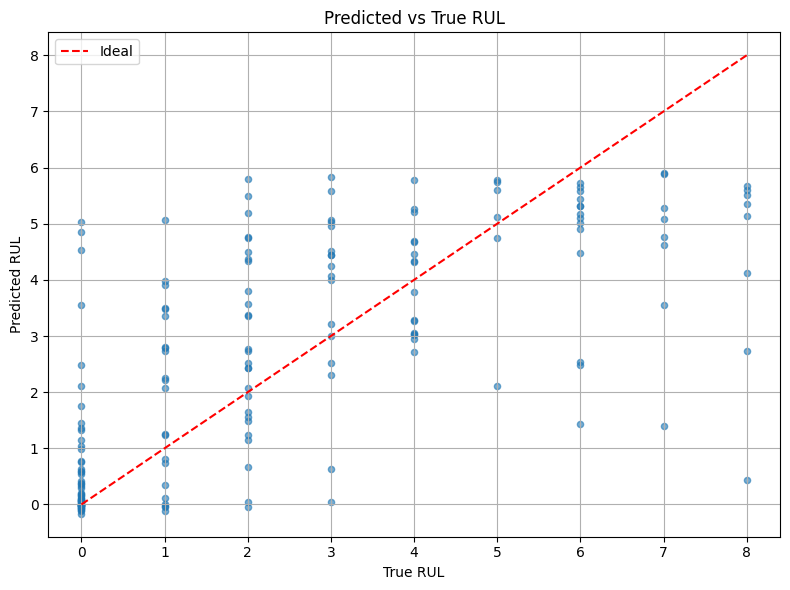


📊 Per-RUL Bin Performance:
  RUL [0, 1): RMSE=1.57 | MAE=0.99 | R²=-10.68
  RUL [1, 3): RMSE=1.81 | MAE=1.51 | R²=-12.83
  RUL [3, 5): RMSE=1.05 | MAE=0.86 | R²=-4.53
  RUL [5, 8): RMSE=2.88 | MAE=2.29 | R²=-10.94


<ipython-input-92-5d8a660c5276>:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = results_df.groupby('rul_bin')


In [ ]:
def evaluate_on_test(row_index, df, save=False, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    # 1. Load best model weights from 'results'

    # Extract hyperparameters from the row:
    hparams = df.loc[row_index, ['rep_hidden_dim', 'lstm_hidden_dim', 'learning_rate', 'batch_size', 'dropout', 'num_lstm_layers', 'window_size', 'balance_ratio', 'near_failure_ratio']].to_dict()

    # Convert relevant hyperparameters to int:
    hparams['rep_hidden_dim'] = int(hparams['rep_hidden_dim'])
    hparams['lstm_hidden_dim'] = int(hparams['lstm_hidden_dim'])
    hparams['batch_size'] = int(hparams['batch_size'])
    hparams['num_lstm_layers'] = int(hparams['num_lstm_layers'])
    hparams['window_size'] = int(hparams['window_size'])  # Add window_size
    hparams['balance_ratio'] = float(hparams['balance_ratio'])
    hparams['near_failure_ratio'] = float(hparams['near_failure_ratio'])

    model_path = df.loc[row_index, 'best_model_state']

    # 2. Reconstruct a model with the same architecture/params used in training

    model = LSTMFailurePredictor(
        frame_dim=7,
        rep_hidden_dim=hparams['rep_hidden_dim'],
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        dropout=hparams['dropout'],
        num_lstm_layers=hparams['num_lstm_layers'],
        window_size=hparams['window_size']
    ).to(device)

    # 3. Load the weights

    buffer = io.BytesIO(model_path)
    best_model_state = torch.load(buffer)

    model.load_state_dict(best_model_state)
    model.eval()

    if save:
        torch.save(model.state_dict(), 'best_model.pth')



    # 4. Create DataLoader for test set
    test_dataset = SlidingWindowRepDataset(test_data, balance_ratio=hparams['balance_ratio'], near_failure_ratio=hparams['near_failure_ratio'])
    test_loader  = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)

    # 5. Inference loop
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for reps, rul_targets in test_loader:
            reps, rul_targets = reps.to(device), rul_targets.to(device)
            preds = model(reps)  # shape: (batch,)
            all_preds.append(preds.cpu())
            all_targets.append(rul_targets.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np

    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.scatter(all_targets, all_preds, alpha=0.6, s=20)
    plt.plot([0, all_targets.max()], [0, all_targets.max()], 'r--', label='Ideal')
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Predicted vs True RUL")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig("rul_eval_plot.png", dpi=200)
    else:
        plt.show()

    import pandas as pd

    # Create a DataFrame for analysis
    results_df = pd.DataFrame({
        'true_rul': all_targets.numpy(),
        'pred_rul': all_preds.numpy()
    })

    # Define RUL bins (you can tweak these)
    bin_edges = [0, 1, 3, 5, 8, 12, 25]  # <- customize depending on your max RUL
    bin_labels = [f"[{bin_edges[i]}, {bin_edges[i+1]})" for i in range(len(bin_edges)-1)]
    results_df['rul_bin'] = pd.cut(results_df['true_rul'], bins=bin_edges, labels=bin_labels, include_lowest=True)

    # Group and compute metrics
    grouped = results_df.groupby('rul_bin')

    print("\n📊 Per-RUL Bin Performance:")
    for name, group in grouped:
        y_true = group['true_rul'].values
        y_pred = group['pred_rul'].values

        if len(y_true) < 3:
            continue  # skip small bins

        bin_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        bin_mae = mean_absolute_error(y_true, y_pred)
        bin_r2 = r2_score(y_true, y_pred)

        print(f"  RUL {name}: RMSE={bin_rmse:.2f} | MAE={bin_mae:.2f} | R²={bin_r2:.2f}")




df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

evaluate_on_test(0, df, save=False)

In [ ]:
from collections import defaultdict, deque

def evaluate_online_inference(row_index, df, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    """Evaluates online inference using a saved model and test data."""
    # 1. Load the model
    hparams = df.loc[row_index, ['rep_hidden_dim', 'lstm_hidden_dim', 'learning_rate', 'batch_size', 'dropout', 'num_lstm_layers', 'window_size']].to_dict()

    # Convert relevant hyperparameters to int:
    hparams['rep_hidden_dim'] = int(hparams['rep_hidden_dim'])
    hparams['lstm_hidden_dim'] = int(hparams['lstm_hidden_dim'])
    hparams['batch_size'] = int(hparams['batch_size'])
    hparams['num_lstm_layers'] = int(hparams['num_lstm_layers'])
    hparams['window_size'] = int(hparams['window_size'])  # Add window_size

    model_path = df.loc[row_index, 'best_model_state']

    # 2. Reconstruct a model with the same architecture/params used in training

    model = LSTMFailurePredictor(
        frame_dim=7,
        rep_hidden_dim=hparams['rep_hidden_dim'],
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        dropout=hparams['dropout'],
        num_lstm_layers=hparams['num_lstm_layers'],
        window_size=hparams['window_size']
    ).to(device)

    # 3. Load the weights

    buffer = io.BytesIO(model_path)
    best_model_state = torch.load(buffer)

    model.load_state_dict(best_model_state)
    model.eval()

    # 2. Prepare data and window
    window = deque(maxlen=hparams['window_size'])
    random_key = random.choice(list(test_data.keys()))
    incoming_reps = np.stack(test_data[random_key], axis=0)

    print(f"Video set: {random_key}")
    print("Total number of reps: ", len(incoming_reps))

    # 3. Online inference loop
    all_logits = []
    all_labels = []
    for t, rep in enumerate(incoming_reps):
        window.append(rep)

        if len(window) == hparams['window_size']:
            input_tensor = torch.tensor([list(window)], dtype=torch.float32).to(device)
            logit = model(input_tensor)
            prob = torch.sigmoid(logit).item()

            print(f"Rep {t}: P(fail) = {prob:.4f}")

            all_logits.append(logit.cpu().item())  # Store logit (not probability)
            all_labels.append(1 if t == len(incoming_reps) - 1 else 0)  # Label as failure only if it's the last rep

            if prob > 0.5:
                print(f"🔥 FAIL detected at rep {t}! Model stops.")
                break

    return all_logits, all_labels, random_key  # Return logits, labels, and video key


df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

evaluate_online_inference(0, df)


Video set: IMG_6017.mp4_set_0
Total number of reps:  13
Rep 2: P(fail) = 0.3507
Rep 3: P(fail) = 0.4558
Rep 4: P(fail) = 0.2394
Rep 5: P(fail) = 0.5317
🔥 FAIL detected at rep 5! Model stops.


([-0.6161724925041199,
  -0.1771983951330185,
  -1.1561952829360962,
  0.12678304314613342],
 [0, 0, 0, 0],
 'IMG_6017.mp4_set_0')

In [ ]:
import io
from collections import defaultdict, deque

def evaluate_distance_metrics(row_index, df, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    """Evaluates online inference using a saved model and test data."""
    # 1. Load the model
    hparams = df.loc[row_index, ['rep_hidden_dim', 'lstm_hidden_dim', 'learning_rate', 'batch_size', 'dropout', 'num_lstm_layers', 'window_size']].to_dict()

    # Convert relevant hyperparameters to int:
    hparams['rep_hidden_dim'] = int(hparams['rep_hidden_dim'])
    hparams['lstm_hidden_dim'] = int(hparams['lstm_hidden_dim'])
    hparams['batch_size'] = int(hparams['batch_size'])
    hparams['num_lstm_layers'] = int(hparams['num_lstm_layers'])
    hparams['window_size'] = int(hparams['window_size'])  # Add window_size




    # 2. Reconstruct a model with the same architecture/params used in training

    model = LSTMFailurePredictor(
        frame_dim=7,
        rep_hidden_dim=hparams['rep_hidden_dim'],
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        dropout=hparams['dropout'],
        num_lstm_layers=hparams['num_lstm_layers'],
        window_size=hparams['window_size']
    ).to(device)

    # 3. Load the weights

    model_path = df.loc[row_index, 'best_model_state']

    buffer = io.BytesIO(model_path)
    best_model_state = torch.load(buffer)

    model.load_state_dict(best_model_state)


    model.eval()

    distances = []

    with torch.no_grad():
        for key, list_of_reps in test_data.items():
            # Check if list_of_reps is empty
            if not list_of_reps:
                print(f"Skipping video '{key}' because it has no reps.")
                continue  # Skip to the next video

            reps = np.stack(list_of_reps, axis=0)  # shape (R, 10, frame_dim)
            R = reps.shape[0]

            # If we have fewer than 3 reps, skip because our model needs 3 for the first prediction
            if R < 7:
                continue

            window = deque(maxlen=3)
            predicted_fail_idx = None  # Will store the index where model first says "fail"

            for t in range(R-7, R):
                rep = reps[t]
                window.append(rep)

                # Only start predicting once we have a full window of 3
                if len(window) == 3:
                    input_tensor = torch.tensor([list(window)], dtype=torch.float32).to(device)  # Move to correct device

                    logit = model(input_tensor)
                    prob = torch.sigmoid(logit).item()

                    if prob > 0.5:
                        predicted_fail_idx = t
                        break

            # The *actual* fail is the last rep in this sequence
            actual_fail_idx = R - 1

            # Compute the difference (pred - actual). If no fail predicted, store a large penalty
            if predicted_fail_idx is not None:
                dist = predicted_fail_idx - actual_fail_idx
            else:
                dist = None  # No prediction made

            distances.append(dist)
    print("Distances:", distances)


    # Filter out any None distances (for sequences where no fail was predicted)
    valid_distances = [d for d in distances if d is not None]

    # Compute additional statistics if there are valid distances
    if len(valid_distances) > 0:
        mean_distance = np.mean(valid_distances)
        median_distance = np.median(valid_distances)
        std_dev_distance = np.std(valid_distances)
        min_distance = np.min(valid_distances)
        max_distance = np.max(valid_distances)

        print("\n📊 **Failure Prediction Metrics** 📊")
        print(f"➡ Mean Distance:  {mean_distance:.4f}")
        print(f"➡ Median Distance: {median_distance:.4f}")
        print(f"➡ Std Deviation:  {std_dev_distance:.4f}")
        print(f"➡ Min Distance:   {min_distance}")
        print(f"➡ Max Distance:   {max_distance}")
        print("(Negative => model predicted failure before actual fail)")
    else:
        print("No fail was ever predicted on the validation set (all predicted_fail_idx were None).")

df = pd.DataFrame(all_results)

# Expand hyperparameters into separate columns
hparams_df = pd.json_normalize(df["hparams"])
df = df.drop(columns=["hparams"]).join(hparams_df)

evaluate_distance_metrics(1, df)


Distances: [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4]

📊 **Failure Prediction Metrics** 📊
➡ Mean Distance:  -4.0000
➡ Median Distance: -4.0000
➡ Std Deviation:  0.0000
➡ Min Distance:   -4
➡ Max Distance:   -4
(Negative => model predicted failure before actual fail)
